In [1]:
import numpy as np
from plot import plot, plot_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statistics
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from bct.algorithms import(centrality, clustering, degree, distance, modularity, core, similarity, efficiency)
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [2]:
palette_nodewise = ['#619eff', '#a9d8fc']
palette_efficiency = ['#21d13c', '#9fedab']
palette_global = ['#b146e3', '#cf9ee6']
# palette_nodewise = ['#de4f43', '#ff968c']
# palette_clustering = ['#f7ad0c', '#fcd372']

# Data visualisation

In [3]:
def plot_hist_distribution(dataset_t1, dataset_t2, dataset_t3, title):
    data1 = dataset_t1.flatten()
    data2 = dataset_t2.flatten()
    data3 = dataset_t3.flatten()
    
    # Plot histogram
    plt.figure(figsize=(12, 8))
    plt.hist(data1, bins=30, alpha=0.3, label='Timepoint 1', color='darkblue')
    plt.hist(data2, bins=30, alpha=0.3, label='Timepoint 2', color='forestgreen')
    plt.hist(data3, bins=30, alpha=0.3, label='Timepoint 3', color='red')

    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [4]:
dataset = np.load("datasets/multivariate_simulation_data_2.npy")
dataset_t1 = dataset[:,0,:,:,0]
dataset_t2 = dataset[:,1,:,:,0]
dataset_t3 = dataset[:,2,:,:,0]

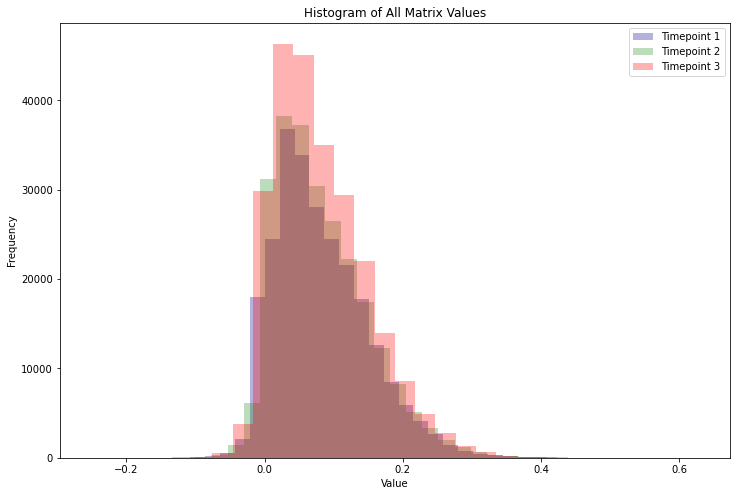

In [5]:
plot_hist_distribution(dataset_t1, dataset_t2, dataset_t3, 'Histogram of All Matrix Values')

In [36]:
def visualization(ground_truth_matrices, predicted_matrices):
    predicted_flat = predicted_matrices.reshape(ground_truth_matrices.shape[0], -1) 
    ground_truth_flat = ground_truth_matrices.reshape(predicted_matrices.shape[0], -1)
    
    all_data = np.vstack((predicted_flat, ground_truth_flat))
    labels = np.array(['Predicted']*40 + ['Ground truth']*40)
    
    tsne = TSNE(n_components=2, random_state=42)

    transformed_data = tsne.fit_transform(all_data)

    colors = ['red' if label == 'Predicted' else 'blue' for label in labels]
    plt.figure(figsize=(10, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=colors, label=labels)

    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.title('t-SNE Visualization of Predicted vs Ground Truth Matrices')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Ground truth')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [37]:
def load_test_results(file_path, n_folds, dataset_size, n_times):
    mae_across_all_folds = np.zeros((n_folds, n_times))
    mem_cap_across_all_folds = np.zeros((n_folds, n_times))
    predicted_across_all_folds = np.zeros((n_folds, dataset_size, n_times, 35, 35))
    original_across_all_folds = np.zeros((n_folds, dataset_size, n_times, 35, 35))
    for f in range(n_folds):
        maes = np.load(file_path+f"test_mae_losses/mae_test_loss_fold_{f}.npy")
        mae_across_all_folds[f] = maes
        mem_caps = np.load(file_path+f"test_memcap_losses/memcap_test_loss_fold_{f}.npy")
        mem_cap_across_all_folds[f] = mem_caps
        predicted = np.load(file_path+f"test_predicted/predicted_fold_{f}.npy")    
        predicted_across_all_folds[f] = predicted
        original = np.load(file_path+f"test_original/original_fold_{f}.npy")
        original_across_all_folds[f] = original
    return mae_across_all_folds, mem_cap_across_all_folds, predicted_across_all_folds, original_across_all_folds

In [38]:
def print_mean_std(data, baseline_data):
    data_mean = statistics.mean(data)
    baseline_mean = statistics.mean(baseline_data)
    data_std = statistics.stdev(data)
    baseline_std = statistics.stdev(baseline_data)
    print(f"Mean: {statistics.mean(data)}")
    print(f"Standard Deviation {statistics.stdev(data)}")
    print(f"Baseline Mean: {statistics.mean(baseline_data)}")
    print(f"Baseline Standard Deviation {statistics.stdev(baseline_data)}")
    return data_mean, baseline_mean, data_std, baseline_std

In [39]:
def plot_comparison(data_across_all_folds, baseline_data_across_all_folds, title, y_label, timepoint, y_lim=None, palette='Set2'):
    # Extract column from the data results
    data = data_across_all_folds[:, timepoint]
    baseline_data = baseline_data_across_all_folds[:, timepoint]
    
    # Calculate the average and append to the arrays
    data_mean, baseline_mean, data_std, baseline_std = print_mean_std(data, baseline_data)
    
    data = np.append(data, data_mean)
    baseline_data = np.append(baseline_data, baseline_mean)
    
    data_dict = {
        'Fold': ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Average Across Folds'],
        'With Reservoir': data,  
        'Baseline': baseline_data    
    }
    
    df_long = pd.DataFrame(data_dict).melt(id_vars=['Fold'], var_name='Type', value_name=y_label)
    
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif'],
        'text.usetex': False
    })
    plt.xticks(rotation=10)

    barplot = sns.barplot(x='Fold', y=y_label, hue='Type', data=df_long, palette=palette, width=0.7)
    barplot.spines['top'].set_visible(False)
    barplot.spines['right'].set_visible(False)
    barplot.spines['left'].set_visible(False)
    barplot.spines['bottom'].set_color('#DDDDDD')

    barplot.tick_params(bottom=False, left=False)

    barplot.set_axisbelow(True)
    barplot.yaxis.grid(True, color='#EEEEEE')
    barplot.xaxis.grid(False)

    barplot.set_xlabel(barplot.get_xlabel(), labelpad=15)
    barplot.set_ylabel(barplot.get_ylabel(), labelpad=15)
    barplot.set_title(title, pad=20)

    # Adding error bars manually for the mean values only
    n_groups = len(data) - 1  # Number of groups without the mean
    x_coords = [n_groups - 0.165, n_groups + 0.15]  # X coordinates of the mean bars
    errors = [data_std, baseline_std]
    plt.errorbar(x_coords, [data_mean, baseline_mean], yerr=errors, fmt='none', c='black', capsize=5)
    # def y_axis_format(x, pos):
    #     return f'{x:.4f}'
    
    # barplot.yaxis.set_major_formatter(FuncFormatter(y_axis_format))
    if y_lim is not None:
        plt.ylim(*y_lim)
        
    barplot.legend_.remove()
    
    plt.title(title)
    plt.show()

# GConvGRU

In [10]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gconvGRU/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

In [11]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gconvGRU/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 5, 40, 2)

## MAE

Mean: 0.032910353541374206
Standard Deviation 0.0010529868871114211
Baseline Mean: 0.03226679563522339
Baseline Standard Deviation 0.0010862633196986077


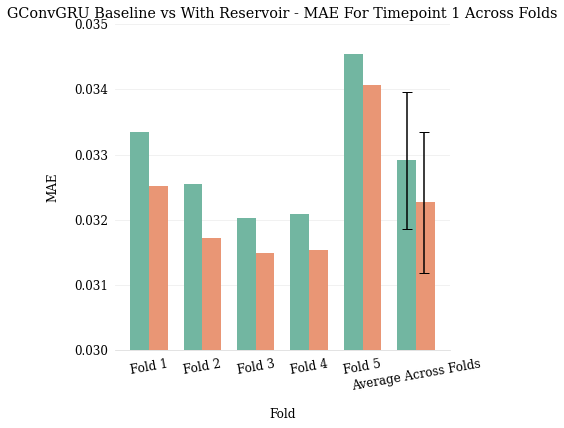

In [18]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.03, 0.035))

Mean: 0.03422801494598388
Standard Deviation 0.00045703196927295194
Baseline Mean: 0.03352815151214599
Baseline Standard Deviation 0.0006067111873112885


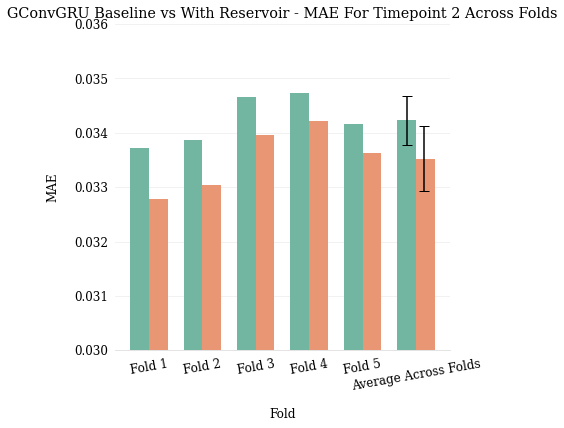

In [19]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.03, 0.036))

## MAE between Mem Caps

Mean: 0.7091209318257945
Standard Deviation 0.08600866650836499
Baseline Mean: 0.9941947265713172
Baseline Standard Deviation 0.07969670286405911


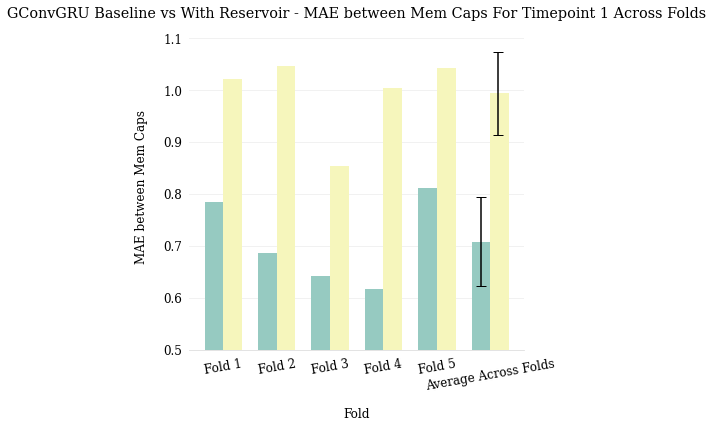

In [15]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.5,), 'Set3')

Mean: 1.0050108024550164
Standard Deviation 0.04898477037787264
Baseline Mean: 1.08089931036808
Baseline Standard Deviation 0.02362912347085426


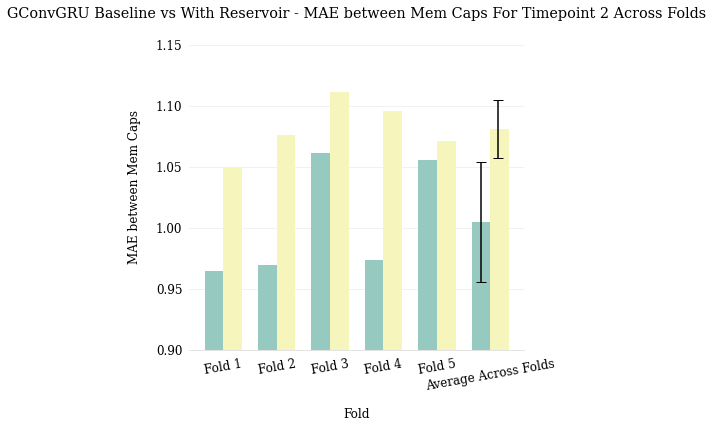

In [16]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.9,), 'Set3')

## Time and Memory Costs

In [57]:
baseline_gconvGRU_times = [461.819, 461.127, 461.057, 460.002, 465.900]
baseline_gconvGRU_memory_usage_MB = [2769.36, 2738.30, 2736.94, 2732.15, 2731.77]

In [58]:
reservoir_gconvGRU_times = [1770.148, 1754.239, 1741.228, 1742.340, 1742.702]
reservoir_gconvGRU_memory_usage_MB = [2732.45, 2724.10, 2724.20, 2723.00, 2723.41]

In [90]:
print_mean_std(reservoir_gconvGRU_times, baseline_gconvGRU_times)

Mean: 1750.1314
Standard Deviation 12.376480549817028
Baseline Mean: 461.981
Baseline Standard Deviation 2.2849692558106627


In [91]:
print_mean_std(reservoir_gconvGRU_memory_usage_MB, baseline_gconvGRU_memory_usage_MB)

Mean: 2725.432
Standard Deviation 3.9543482395964675
Baseline Mean: 2741.704
Baseline Standard Deviation 15.724984260723474


## Network Topology Similarity

In [40]:
def node_strength_diff(G1, G2):
    mean_node_strengths_1 = statistics.mean(degree.strengths_und(G1))
    mean_node_strengths_2 = statistics.mean(degree.strengths_und(G2))
    
    return abs(mean_node_strengths_1 - mean_node_strengths_2)

In [41]:
def node_degree_diff(G1, G2):
    G1_bin = G1.astype(bool).astype(int)
    G2_bin = G2.astype(bool).astype(int)
    mean_node_degree_1 = statistics.mean(degree.degrees_und(G1_bin))
    mean_node_degree_2 = statistics.mean(degree.degrees_und(G2_bin))
    
    return abs(mean_node_degree_1 - mean_node_degree_2)

In [42]:
def global_efficiency_diff(G1, G2):
    g1 = efficiency.efficiency_wei(G1)
    g2 = efficiency.efficiency_wei(G2)
    return abs(g1 - g2)

In [43]:
def local_efficiency_diff(G1, G2):
    l1 = efficiency.efficiency_wei(G1, local=True)
    l2 = efficiency.efficiency_wei(G2, local=True)
    
    avg_l1 = statistics.mean(l1)
    avg_l2 = statistics.mean(l2)
    
    return abs(avg_l1 - avg_l2)

In [44]:
def participation_coef_diff(G1, G2):
    ci = np.arange(len(G1)) + 1
    
    p1_pos, p1_neg = centrality.participation_coef_sign(G1, ci)
    p2_pos, p2_neg = centrality.participation_coef_sign(G2, ci)

    
    avg_p1_pos = statistics.mean(p1_pos)
    avg_p2_pos = statistics.mean(p2_pos)
    
    avg_p1_neg = statistics.mean(p1_neg)
    avg_p2_neg = statistics.mean(p2_neg)
    
    return abs(avg_p1_pos - avg_p2_pos) + abs(avg_p1_neg - avg_p2_neg)
    

In [45]:
def diversity_coef_diff(G1, G2):
    ci = np.arange(len(G1)) + 1
    
    d1_pos, d1_neg = centrality.diversity_coef_sign(G1, ci)
    d2_pos, d2_neg = centrality.diversity_coef_sign(G2, ci)

    
    avg_d1_pos = statistics.mean(d1_pos)
    avg_d2_pos = statistics.mean(d2_pos)
    
    avg_d1_neg = statistics.mean(d1_neg)
    avg_d2_neg = statistics.mean(d2_neg)
    
    return abs(avg_d1_pos - avg_d2_pos) + abs(avg_d1_neg - avg_d2_neg)
    

In [46]:
def betweeness_centrality_diff(G1, G2):  
    betweenness_centrality1 = centrality.betweenness_wei(G1)
    betweenness_centrality2 = centrality.betweenness_wei(G2)
    
    mean_bc1 = statistics.mean(betweenness_centrality1)
    mean_bc2 = statistics.mean(betweenness_centrality2)
    return abs(mean_bc1 - mean_bc2)

In [47]:
def eigenvector_centrality_diff(G1, G2):
    ec1 = centrality.eigenvector_centrality_und(G1)
    ec2 = centrality.eigenvector_centrality_und(G2)
    
    mean_ec1 = statistics.mean(ec1)
    mean_ec2 = statistics.mean(ec2)
    return abs(mean_ec1 - mean_ec2)

In [48]:
def modularity_diff(G1, G2):
    G1 = nx.from_numpy_array(G1)
    G2 = nx.from_numpy_array(G2)
    
    communities_1 = nx.algorithms.community.greedy_modularity_communities(G1)
    modularity_1 = nx.algorithms.community.modularity(G1, communities_1)
    
    communities_2 = nx.algorithms.community.greedy_modularity_communities(G2)
    modularity_2 = nx.algorithms.community.modularity(G2, communities_2)
    
    return abs(modularity_1 - modularity_2)

In [49]:
def density_diff(G1, G2):
    G1 = nx.from_numpy_array(G1)
    G2 = nx.from_numpy_array(G2)
    
    density_1 = nx.density(G1)
    density_2 = nx.density(G2)
    
    return abs(density_1 - density_2)

In [50]:
def clustering_diff(G1, G2):
    clustering_1 = clustering.transitivity_wu(G1)
    clustering_2 = clustering.transitivity_wu(G2)
    
    return abs(clustering_1 - clustering_2)

In [51]:
def get_diffs_across_folds(diff_func, predicted_across_all_folds, original_across_all_folds):
    total_diff_folds = np.zeros((predicted_across_all_folds.shape[0], predicted_across_all_folds.shape[2]))
    for f in range(predicted_across_all_folds.shape[0]):
        for n_t in range(predicted_across_all_folds.shape[2]):
            total_diff = 0
            for n_subjects in range(predicted_across_all_folds.shape[1]):
                predicted = predicted_across_all_folds[f, n_subjects, n_t, :, :]
                actual = original_across_all_folds[f, n_subjects, n_t, :, :]
                
                total_diff += diff_func(predicted, actual)
            total_diff_folds[f, n_t] = total_diff / predicted_across_all_folds.shape[1]
    return total_diff_folds

### Node Strength

Mean: 0.35274092324201717
Standard Deviation 0.03768256128662925
Baseline Mean: 0.281867380931023
Baseline Standard Deviation 0.027799718291846544


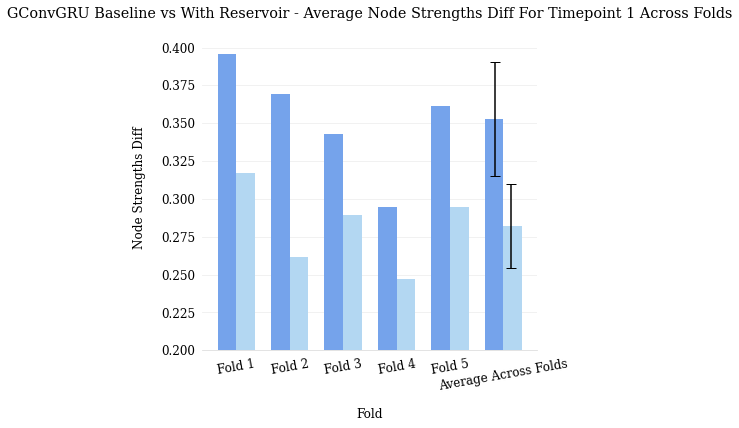

Mean: 0.4359792647333022
Standard Deviation 0.03501580183818153
Baseline Mean: 0.362244550194738
Baseline Standard Deviation 0.04790831991523864


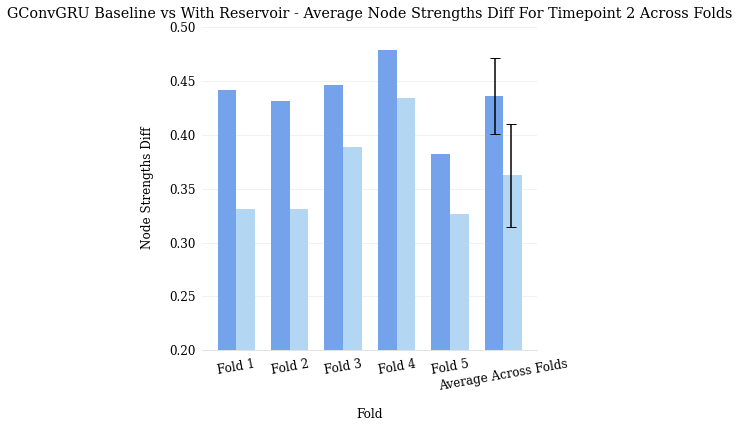

In [65]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.2,), palette_nodewise)

### Centrality

Mean: 0.2106270387136693
Standard Deviation 0.016043955311996556
Baseline Mean: 0.21121829419841964
Baseline Standard Deviation 0.016093691036781575


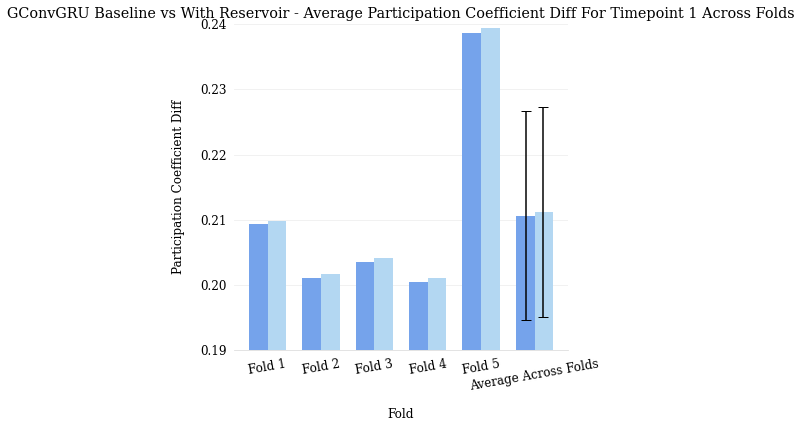

Mean: 0.22636151683709632
Standard Deviation 0.003924596376003197
Baseline Mean: 0.22683185837530914
Baseline Standard Deviation 0.0037814026460013753


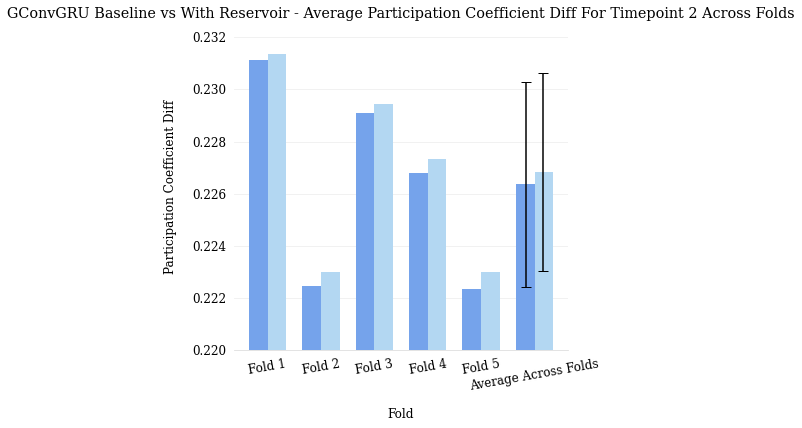

In [64]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.19, 0.24), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.22, 0.2325), palette_nodewise)

Mean: 0.13756872848462873
Standard Deviation 0.011206246825130016
Baseline Mean: 0.14123019554734134
Baseline Standard Deviation 0.01143407080631172


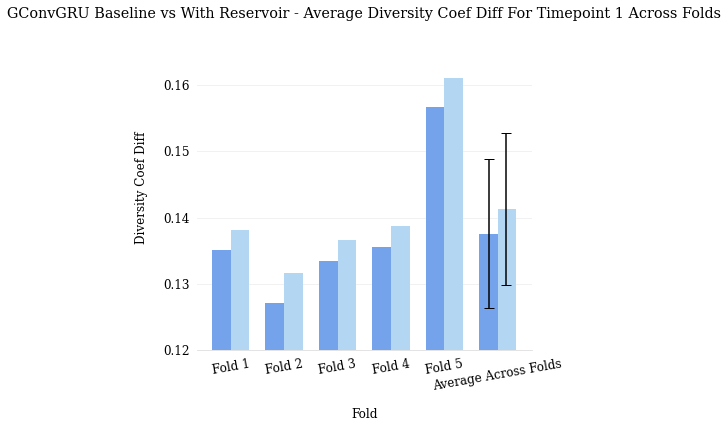

Mean: 0.14579976624805766
Standard Deviation 0.002085060185907132
Baseline Mean: 0.14854321368453902
Baseline Standard Deviation 0.0013478325520401716


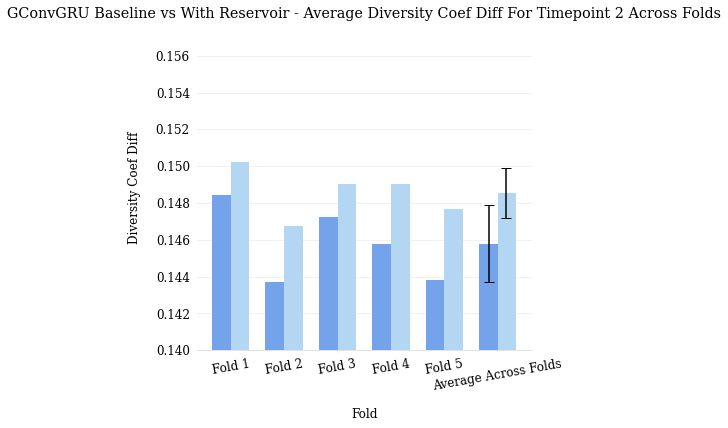

In [67]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.12,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.14,), palette_nodewise)

Mean: 252.2012857142857
Standard Deviation 12.117453073133442
Baseline Mean: 253.3404285714286
Baseline Standard Deviation 12.223135574201352


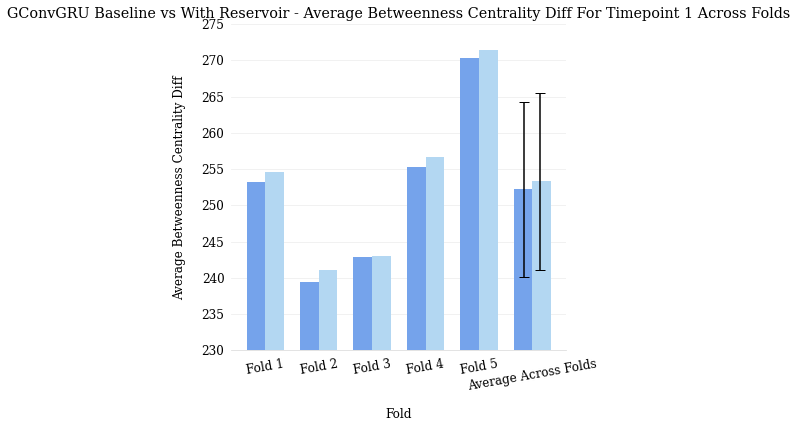

Mean: 264.5212857142857
Standard Deviation 7.550372531017425
Baseline Mean: 264.48314285714287
Baseline Standard Deviation 7.499622415665401


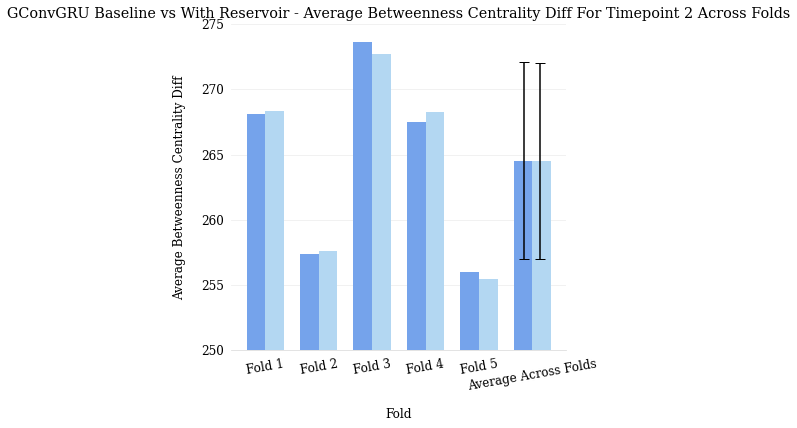

In [68]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (230,275), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (250,275), palette_nodewise)

Mean: 0.003917394571024586
Standard Deviation 0.00029567663446142424
Baseline Mean: 0.003440261229307123
Baseline Standard Deviation 0.00033964771284880884


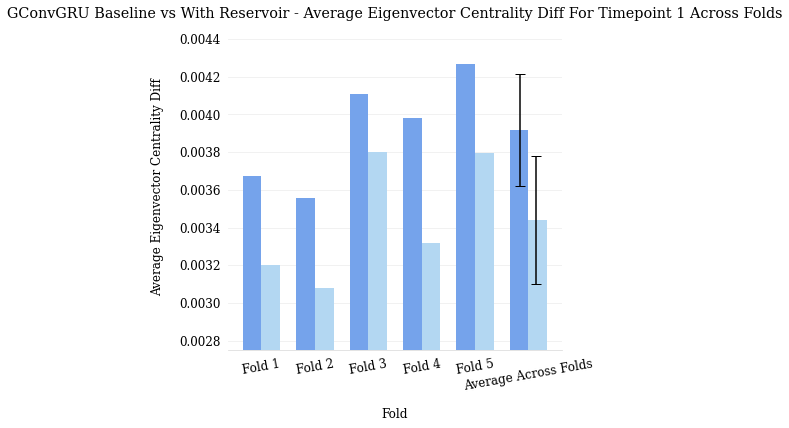

Mean: 0.0046950921082092
Standard Deviation 0.0003205478417714263
Baseline Mean: 0.004452845141427827
Baseline Standard Deviation 0.00037953405345694043


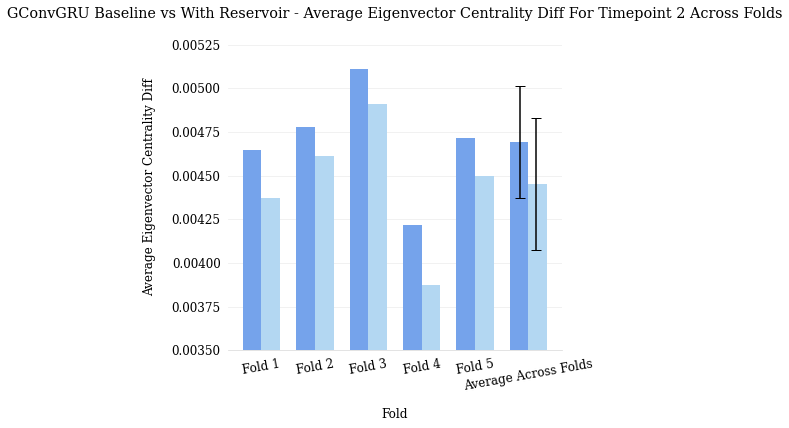

In [70]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.00275,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0035,), palette_nodewise)

### Efficiency

In [71]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.09645368619130838
Standard Deviation 0.001830821797841536
Baseline Mean: 0.10035399909555093
Baseline Standard Deviation 0.0018563326571424505


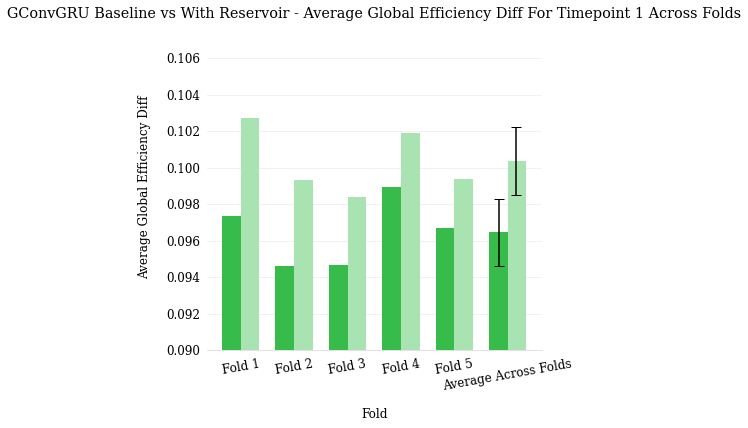

Mean: 0.09255881656667907
Standard Deviation 0.0014284086409604609
Baseline Mean: 0.09604807833037779
Baseline Standard Deviation 0.0009434669100380936


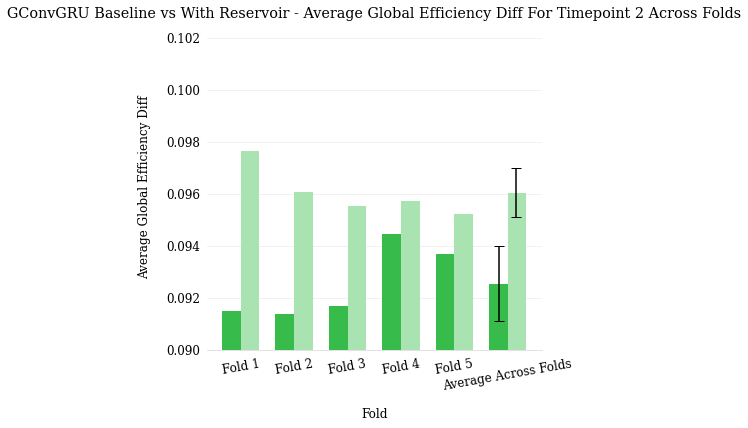

In [75]:
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.09,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.09,), palette_efficiency)

In [73]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.06689996387031155
Standard Deviation 0.002006009753589834
Baseline Mean: 0.0695843114057835
Baseline Standard Deviation 0.0022179622126590384


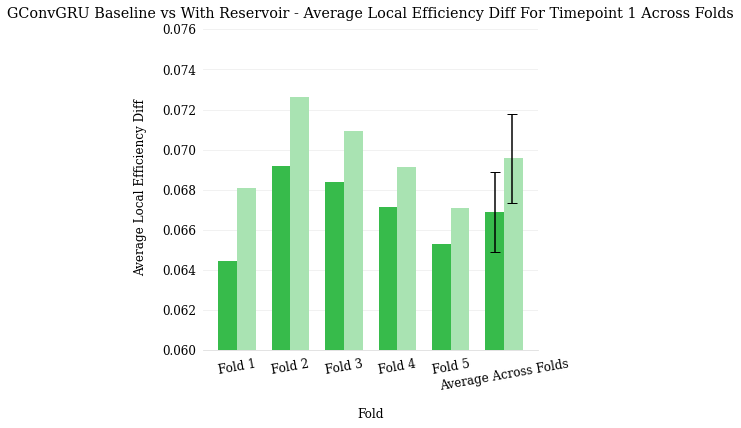

Mean: 0.07031011783142771
Standard Deviation 0.016896469415355372
Baseline Mean: 0.07284042495412045
Baseline Standard Deviation 0.016371963161984353


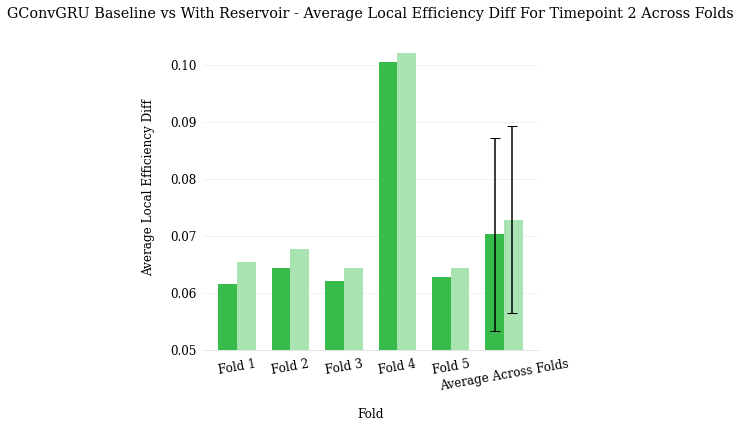

In [77]:
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.06,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.05,), palette_efficiency)

### Modularity

In [78]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.003078004485841743
Standard Deviation 0.00022939381944460762
Baseline Mean: 0.003558519228099451
Baseline Standard Deviation 0.001048098948312037


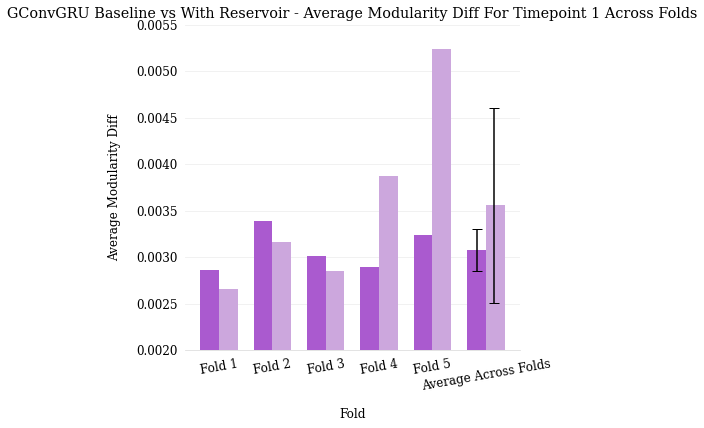

Mean: 0.001531314873044023
Standard Deviation 0.00023026488155372755
Baseline Mean: 0.002287495509589321
Baseline Standard Deviation 0.0008413466350191078


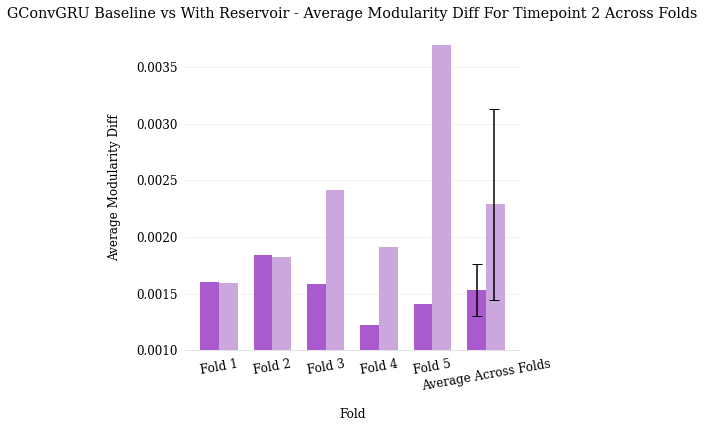

In [82]:
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.001,), palette_global)           

### Density

Mean: 0.04304201680672276
Standard Deviation 0.0009369842106772841
Baseline Mean: 0.047722689075630306
Baseline Standard Deviation 0.0034166149239136328


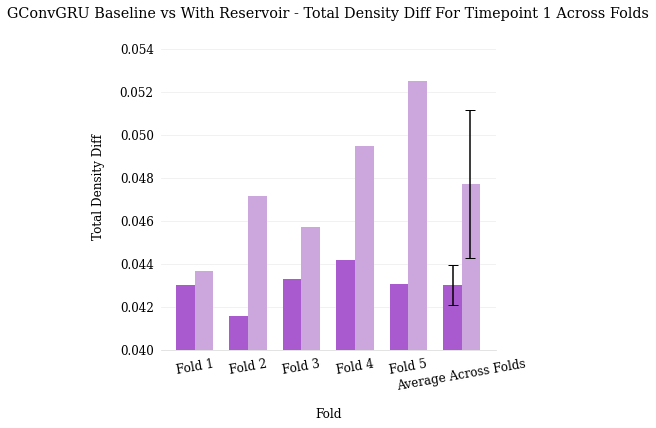

Mean: 0.04206722689075638
Standard Deviation 0.00023469310997930923
Baseline Mean: 0.04415966386554628
Baseline Standard Deviation 0.0015924868620375778


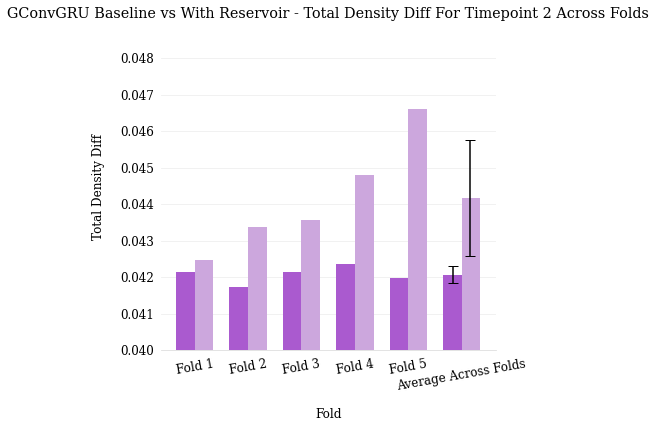

In [84]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.04,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.04,), palette_global)


### Clustering

Mean: 0.009002975601044492
Standard Deviation 0.0010542251560952502
Baseline Mean: 0.010637221177492202
Baseline Standard Deviation 0.0011434052730877934


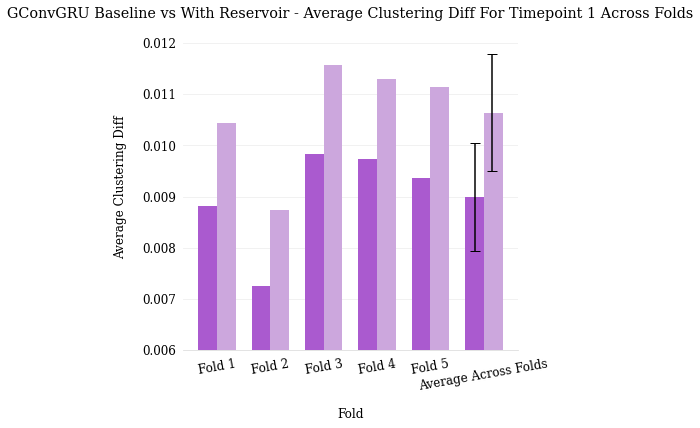

Mean: 0.008479409256844208
Standard Deviation 0.0011280876476060498
Baseline Mean: 0.00936014026957261
Baseline Standard Deviation 0.0006997403549445799


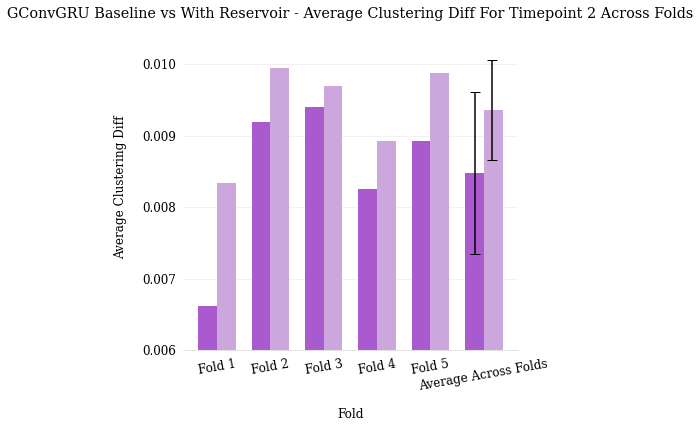

In [85]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.006,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.006,), palette_global)

## GConvLSTM

In [86]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gcLSTM/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gcLSTM/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 5, 40, 2)

Mean: 0.03568460404872894
Standard Deviation 0.001911506166065564
Baseline Mean: 0.03383533477783203
Baseline Standard Deviation 0.0014766570002098926


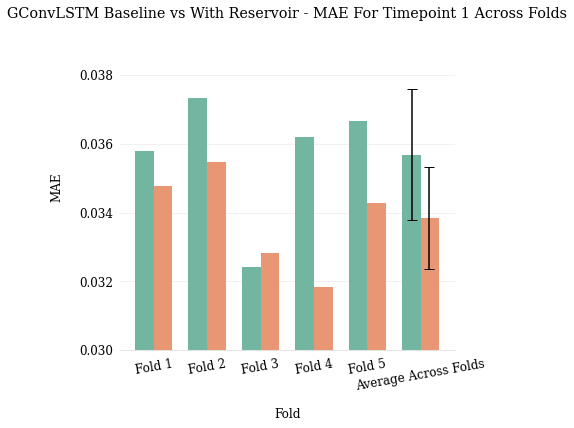

Mean: 0.03713877022266388
Standard Deviation 0.001564089533303884
Baseline Mean: 0.03496593415737152
Baseline Standard Deviation 0.0010848858215093309


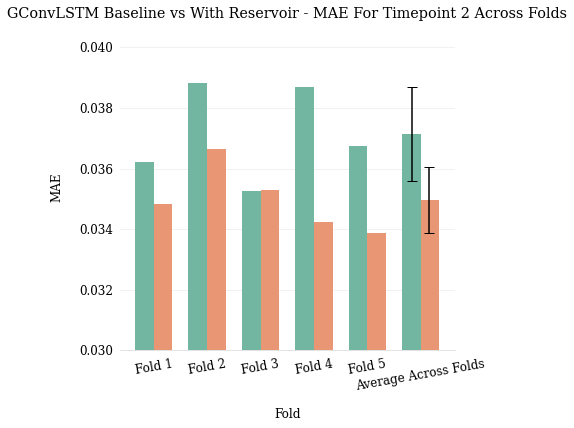

In [87]:
title = 'GConvLSTM Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.03, ))
title = 'GConvLSTM Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.03,))

Mean: 0.8570949712099613
Standard Deviation 0.1256544101641503
Baseline Mean: 1.0225033658250668
Baseline Standard Deviation 0.05324123039378119


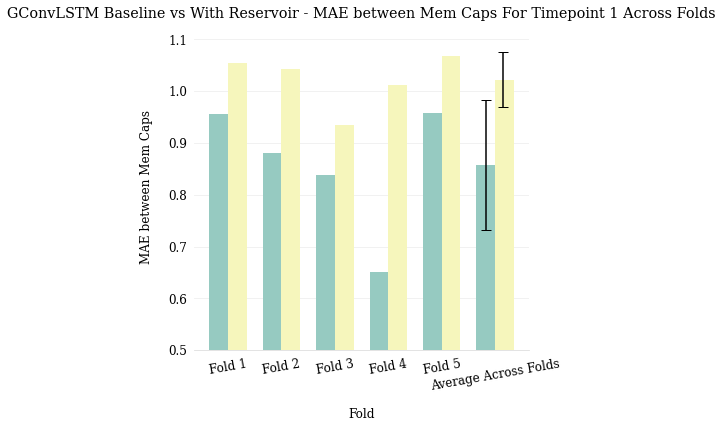

Mean: 1.0259987318587247
Standard Deviation 0.04756659068727247
Baseline Mean: 1.1277314252232216
Baseline Standard Deviation 0.02862568183030475


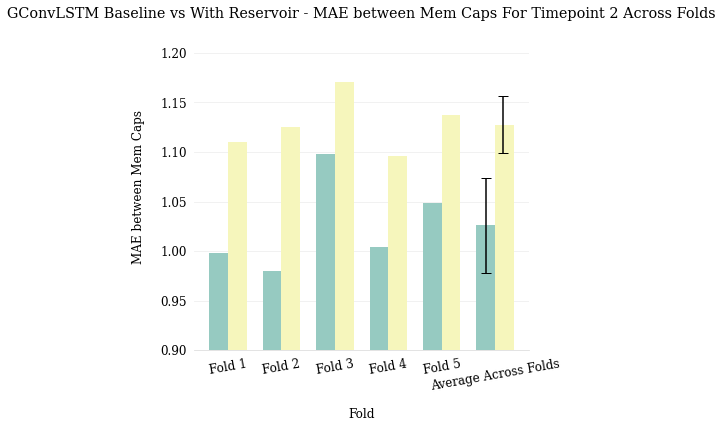

In [88]:
title = 'GConvLSTM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.5,), 'Set3')
title = 'GConvLSTM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.9,), 'Set3')

### Time and Memory Costs

In [37]:
baseline_gcLSTM_times = [370.06, 371.88, 370.13, 370.67, 375.96]
baseline_gcLSTM_memory_usage_MB = [1981.20, 2098.02, 2115.08, 2134.19, 2134.20]
reservoir_gcLSTM_times = [2083.55, 2000.72, 2001.31, 1907.08, 1904.23]
reservoir_gcLSTM_memory_usage_MB = [2652.04, 2652.77, 2653.78, 2654.78, 2656.94]
print_mean_std(reservoir_gcLSTM_times, baseline_gcLSTM_times)
print_mean_std(reservoir_gcLSTM_memory_usage_MB, baseline_gcLSTM_memory_usage_MB)

Mean: 1979.378
Standard Deviation 75.27038242230479
Baseline Mean: 371.74
Baseline Standard Deviation 2.469180025838527
Mean: 2654.062
Standard Deviation 1.9128303636235418
Baseline Mean: 2092.538
Baseline Standard Deviation 64.0409159834554


(2654.062, 2092.538, 1.9128303636235418, 64.0409159834554)

### Node Strength

Mean: 0.46353070179158873
Standard Deviation 0.07303116891699356
Baseline Mean: 0.31047351123343797
Baseline Standard Deviation 0.05000582014412213


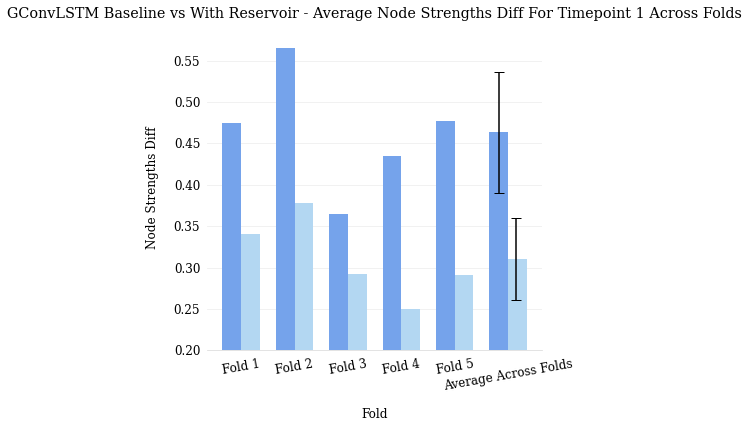

Mean: 0.5457241410808565
Standard Deviation 0.06533630922061863
Baseline Mean: 0.3884207722618517
Baseline Standard Deviation 0.05419893687700414


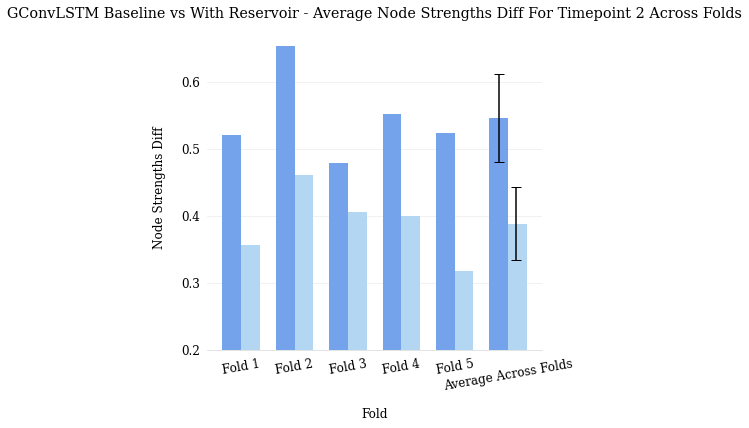

In [103]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.2,), palette_nodewise)

### Centrality

Mean: 0.20970821422726788
Standard Deviation 0.015855874434759103
Baseline Mean: 0.21030585869866247
Baseline Standard Deviation 0.016635764859540183


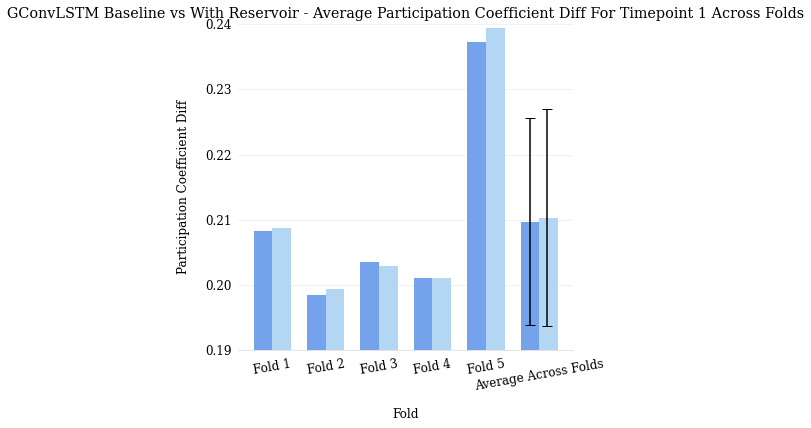

Mean: 0.22611116397717557
Standard Deviation 0.005040100180812314
Baseline Mean: 0.22611994745444416
Baseline Standard Deviation 0.0040273869830125125


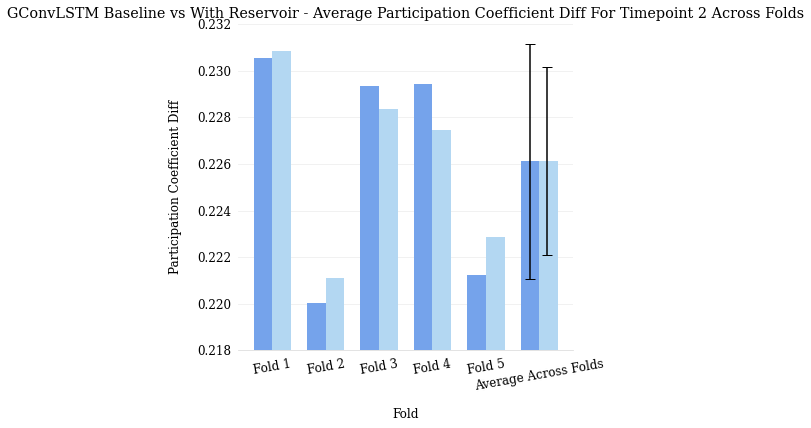

In [90]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.19, 0.24), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.218, 0.232), palette_nodewise)

Mean: 0.13013568903172387
Standard Deviation 0.014019741995769427
Baseline Mean: 0.13487405504689412
Baseline Standard Deviation 0.016540604769654885


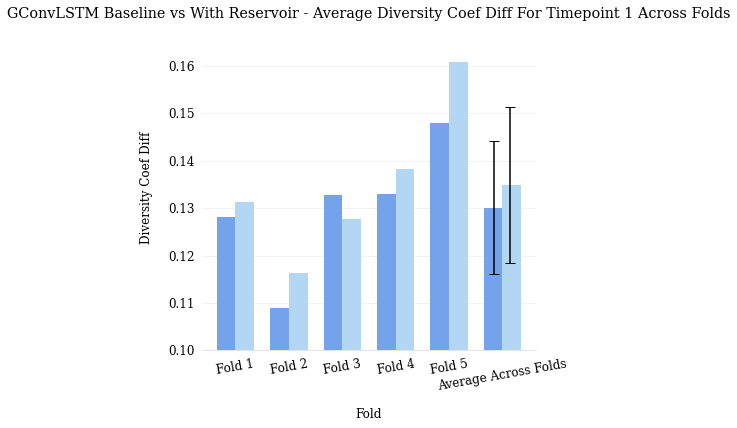

Mean: 0.14186247824855355
Standard Deviation 0.010142328817187827
Baseline Mean: 0.14366100459420947
Baseline Standard Deviation 0.006106242316100896


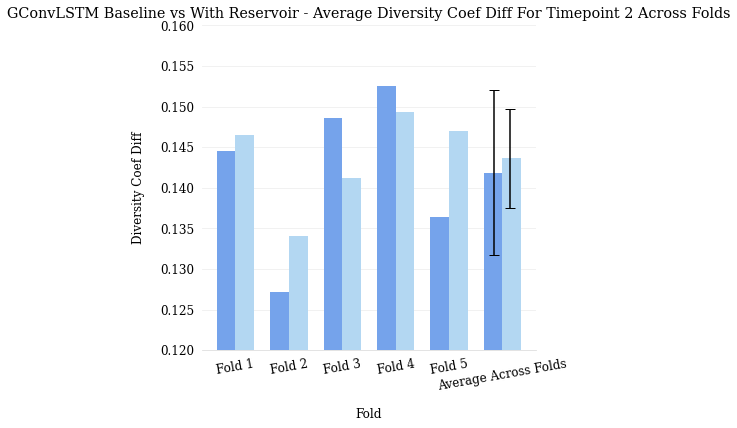

In [91]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.1,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.12,), palette_nodewise)

In [92]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 254.53242857142857
Standard Deviation 11.89195439087677
Baseline Mean: 255.1782857142857
Baseline Standard Deviation 11.348774124664445


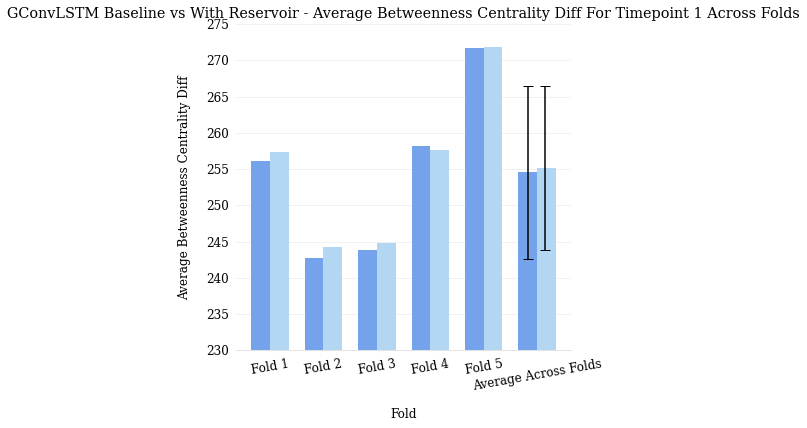

Mean: 268.1821428571429
Standard Deviation 7.044333281265911
Baseline Mean: 267.93699999999995
Baseline Standard Deviation 7.497572215901159


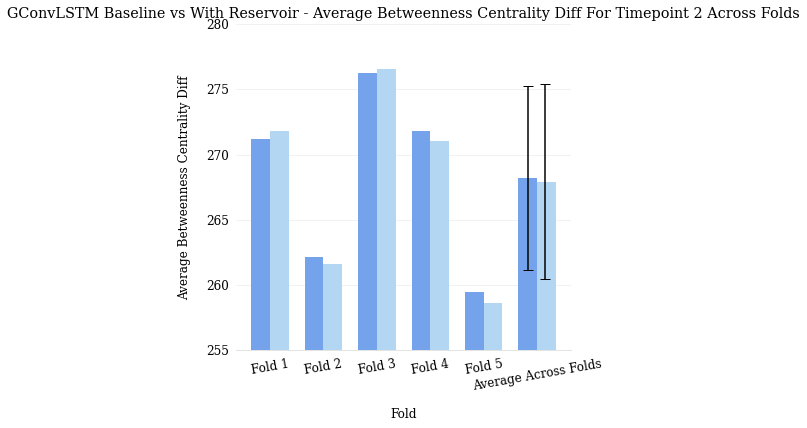

In [93]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (230,275), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (255,280), palette_nodewise)

Mean: 0.003890541307441372
Standard Deviation 0.000637728260799003
Baseline Mean: 0.0037494243708612956
Baseline Standard Deviation 0.00047894745505334816


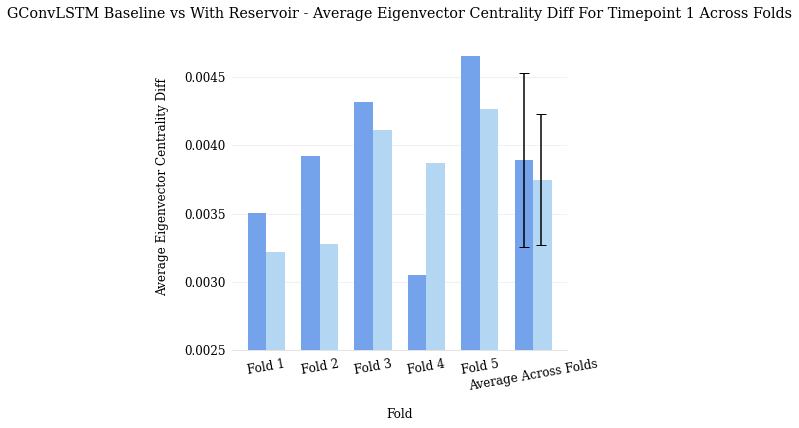

Mean: 0.004953789053455871
Standard Deviation 0.0009448893723900866
Baseline Mean: 0.004863529996614821
Baseline Standard Deviation 0.0005397727465890961


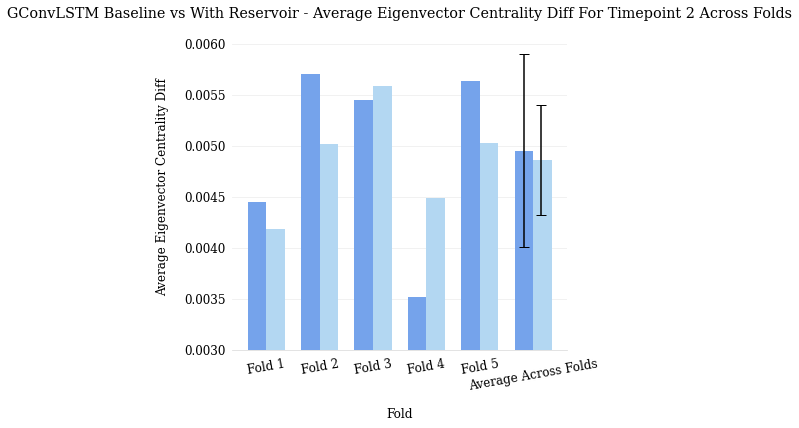

In [94]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.0025,), palette_nodewise)
title = 'GConvLSTM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.003,), palette_nodewise)

### Efficiency

In [95]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.08902036953893062
Standard Deviation 0.005036453335339941
Baseline Mean: 0.09837002126847613
Baseline Standard Deviation 0.003458248285655721


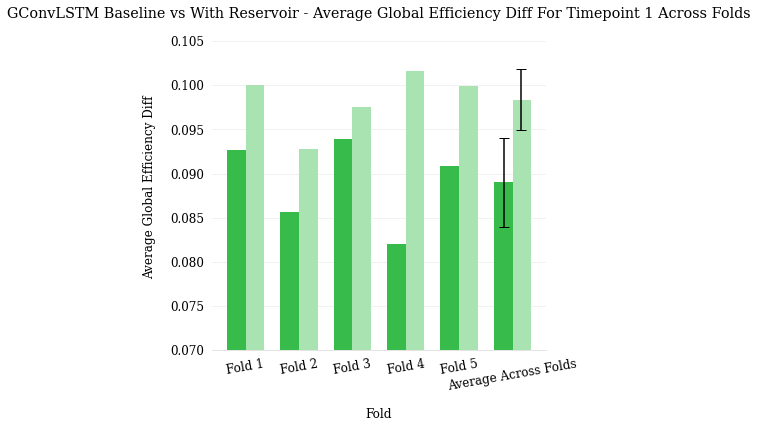

Mean: 0.08358226522474459
Standard Deviation 0.005160239434321836
Baseline Mean: 0.09366426390499302
Baseline Standard Deviation 0.004056606748141017


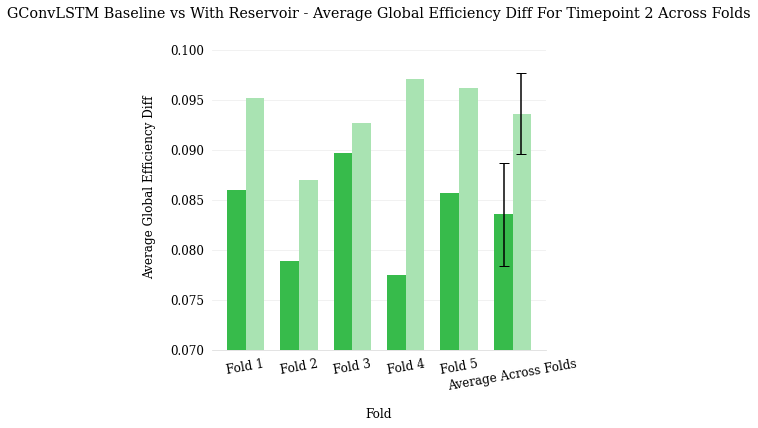

In [96]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.07,), palette_efficiency)
title = 'GConvLSTM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.07,), palette_efficiency)

In [97]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.06492894702112333
Standard Deviation 0.002386020825491221
Baseline Mean: 0.06978410368413945
Baseline Standard Deviation 0.0015654762427558865


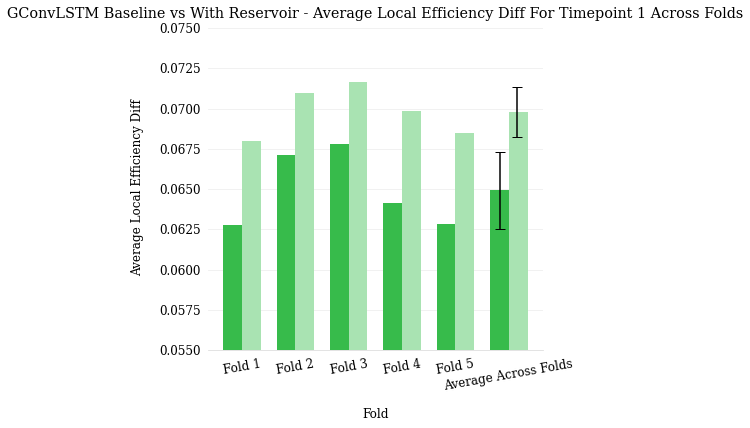

Mean: 0.06885999796958071
Standard Deviation 0.017800789449374386
Baseline Mean: 0.07326013897739189
Baseline Standard Deviation 0.017239089546088486


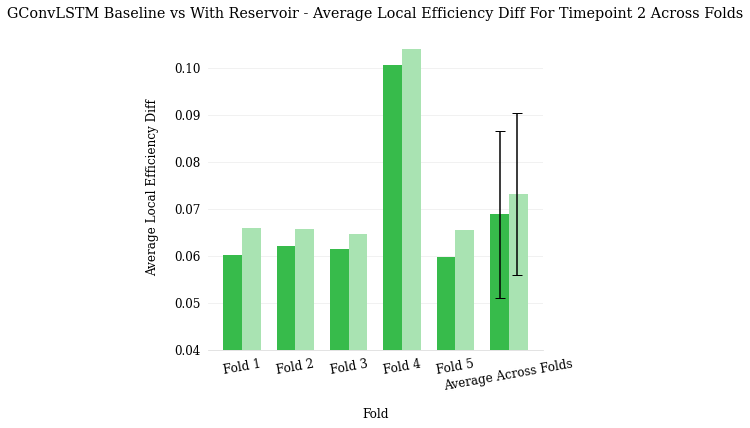

In [104]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.055,), palette_efficiency)
title = 'GConvLSTM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.04,), palette_efficiency)

### Modularity

In [99]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.0030230966805237305
Standard Deviation 0.0015970847973205298
Baseline Mean: 0.0034029083585937776
Baseline Standard Deviation 0.0008907889170272403


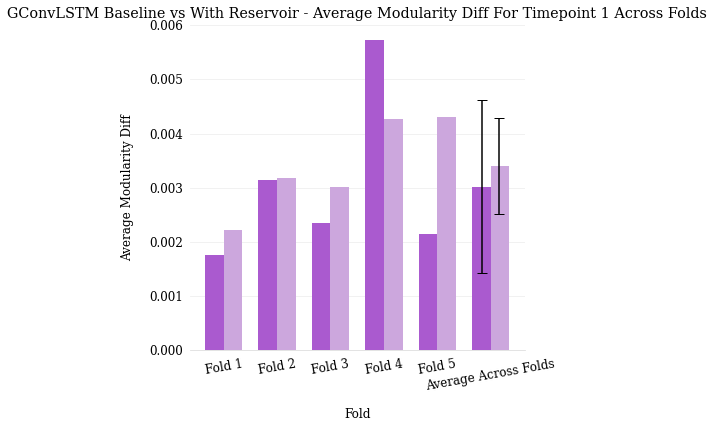

Mean: 0.002747713064321812
Standard Deviation 0.0016331074247167199
Baseline Mean: 0.0032365987835595252
Baseline Standard Deviation 0.0009935599073271574


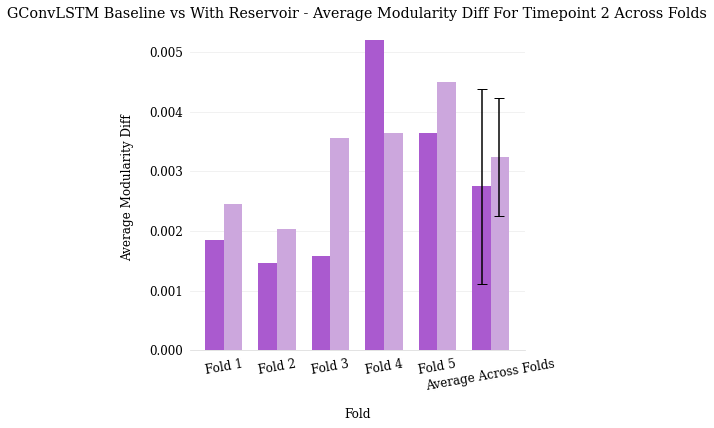

In [100]:
title = 'GConvLSTM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0,), palette_global)           

### Density

Mean: 0.039420168067226966
Standard Deviation 0.004474188226403816
Baseline Mean: 0.047067226890756354
Baseline Standard Deviation 0.003083501201954225


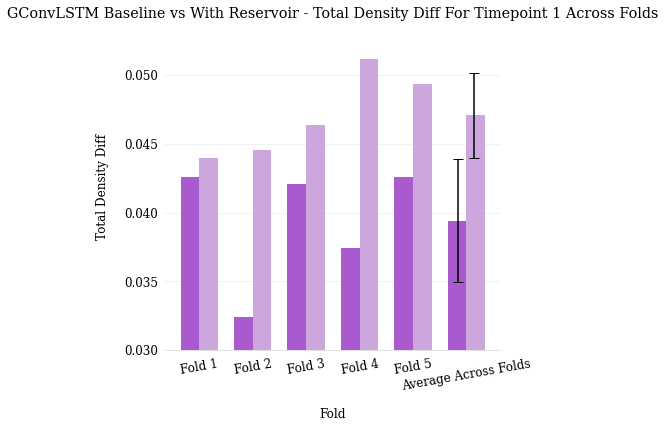

Mean: 0.04040336134453789
Standard Deviation 0.004751578852220673
Baseline Mean: 0.04686554621848745
Baseline Standard Deviation 0.0024844335653276713


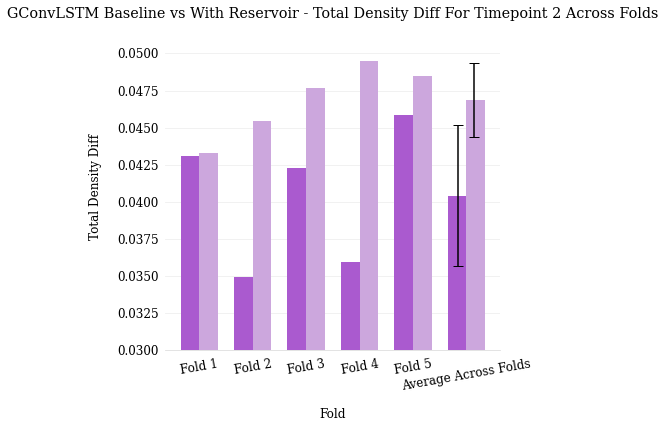

In [101]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvLSTM Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.03,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.03,), palette_global)


### Clustering

Mean: 0.008302044355300693
Standard Deviation 0.000843873748044808
Baseline Mean: 0.010235098217451413
Baseline Standard Deviation 0.0016283030537400688


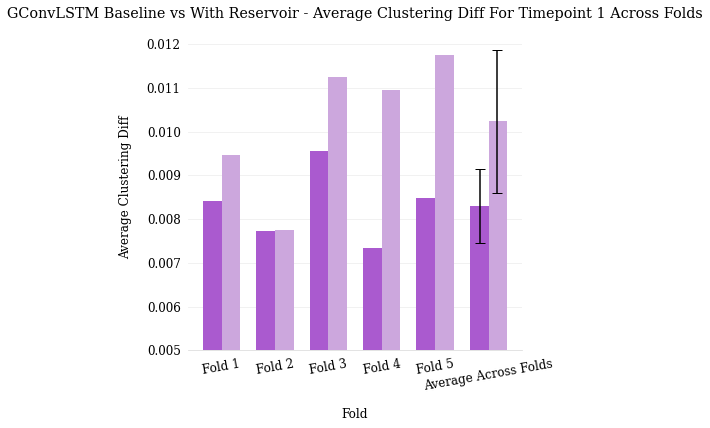

Mean: 0.00844503216603497
Standard Deviation 0.001216290214790621
Baseline Mean: 0.009367824919059747
Baseline Standard Deviation 0.0008958407403611661


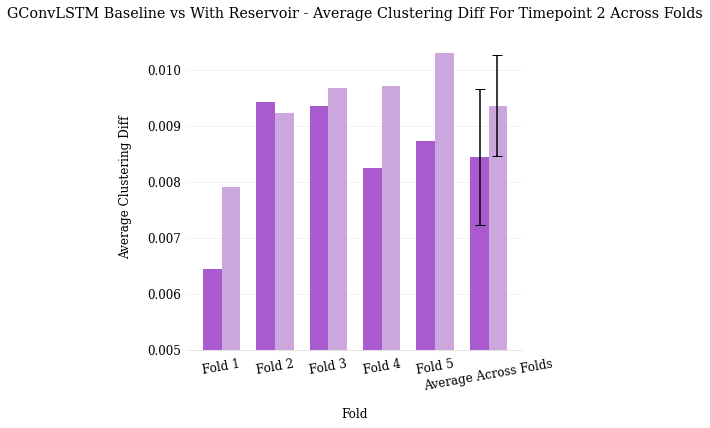

In [105]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvLSTM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.005,), palette_global)
title = 'GConvLSTM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.005,), palette_global)

## TAGConv

In [50]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_tag/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

In [51]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_tag/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 5, 40, 2)

Mean: 0.03358639597892761
Standard Deviation 0.0010564057618256482
Baseline Mean: 0.03319051504135132
Baseline Standard Deviation 0.0010154773247527896


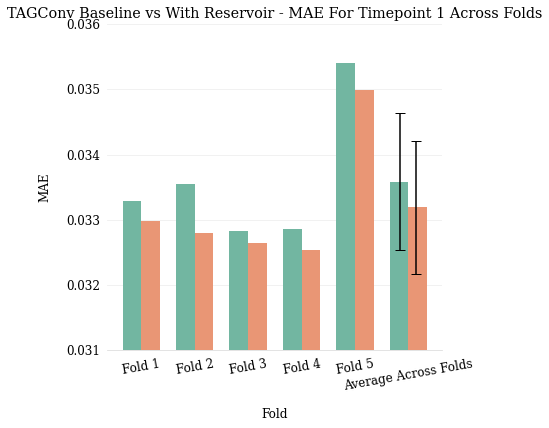

In [47]:
title = 'TAGConv Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.031, 0.036))

Mean: 0.03448378443717957
Standard Deviation 0.0006490539967114044
Baseline Mean: 0.03413334608078003
Baseline Standard Deviation 0.0006670429905831514


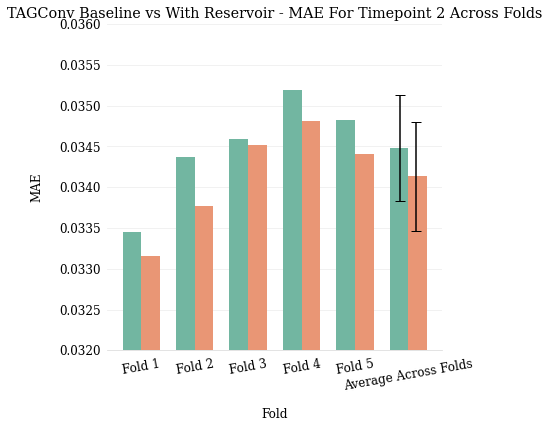

In [50]:
title = 'TAGConv Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.032, 0.036))

Mean: 0.604939082146355
Standard Deviation 0.08514176889254473
Baseline Mean: 0.9605314068500139
Baseline Standard Deviation 0.050220537314396504


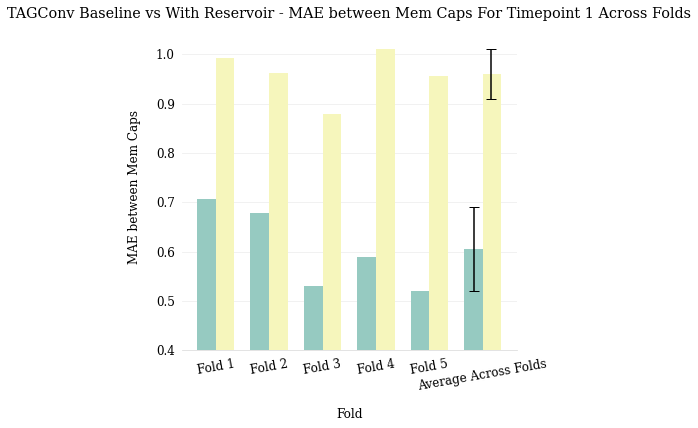

In [19]:
title = 'TAGConv Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.4,), 'Set3')

Mean: 0.9896652228707173
Standard Deviation 0.07197023845103499
Baseline Mean: 1.108374925303327
Baseline Standard Deviation 0.040614192933653676


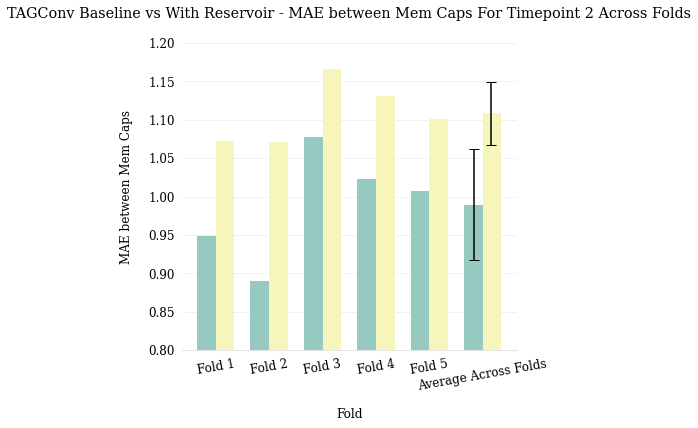

In [20]:
title = 'TAGConv Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.8,), 'Set3')

In [25]:
baseline_tag_times = [1055.605, 1055.210, 1049.613, 1048.814, 1046.322]
baseline_tag_memory_usage_MB = [2110.22, 2050.71, 2122.92, 2057.56, 2119.81]

In [26]:
reservoir_tag_times = [6577.328, 6576.939, 6580.511, 6573.905, 6576.348]
reservoir_tag_memory_usage_MB = [1995.25, 1997.27, 1998.63, 2000.07, 1999.61]

In [25]:
print_mean_std(reservoir_tag_times, baseline_tag_times)

Mean: 6577.0062
Standard Deviation 2.3686685500511055
Baseline Mean: 1051.1128
Baseline Standard Deviation 4.106475216046025


(6577.0062, 1051.1128, 2.3686685500511055, 4.106475216046025)

In [26]:
print_mean_std(reservoir_tag_memory_usage_MB, baseline_tag_memory_usage_MB)

Mean: 1998.166
Standard Deviation 1.9513789995795026
Baseline Mean: 2092.244
Baseline Standard Deviation 35.185547174941


(1998.166, 2092.244, 1.9513789995795026, 35.185547174941)

### Node Strength

Mean: 0.3462752923662292
Standard Deviation 0.03886133168112356
Baseline Mean: 0.2896889679007403
Baseline Standard Deviation 0.03200593500298493


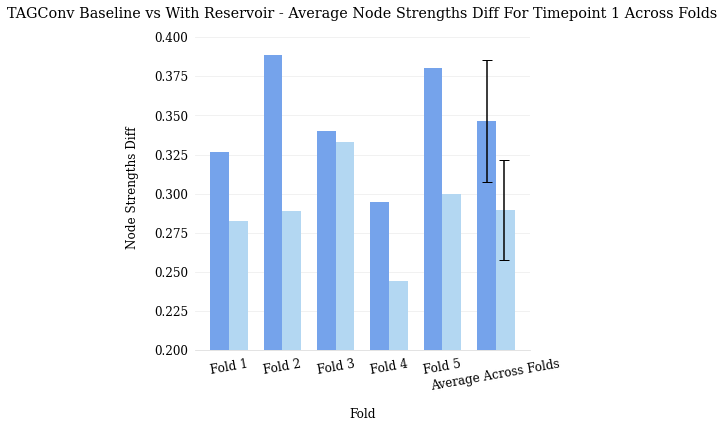

Mean: 0.3680878738487849
Standard Deviation 0.03586918228154523
Baseline Mean: 0.30200448623814896
Baseline Standard Deviation 0.03794442211953177


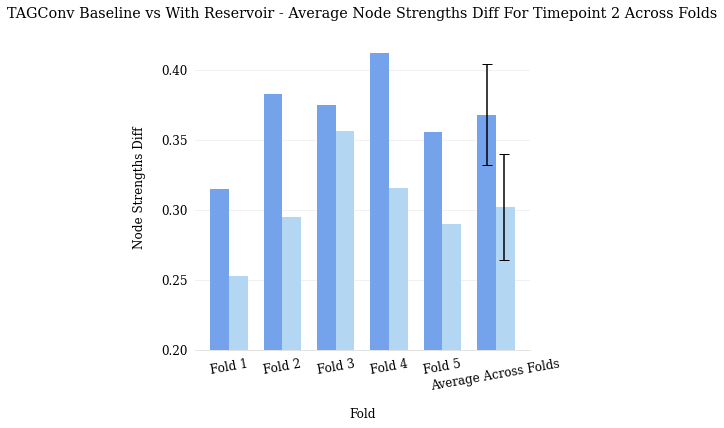

In [52]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.2,), palette_nodewise)

### Centrality

Mean: 0.21084315289152905
Standard Deviation 0.015908514500901035
Baseline Mean: 0.21135971112105786
Baseline Standard Deviation 0.015965922952761193


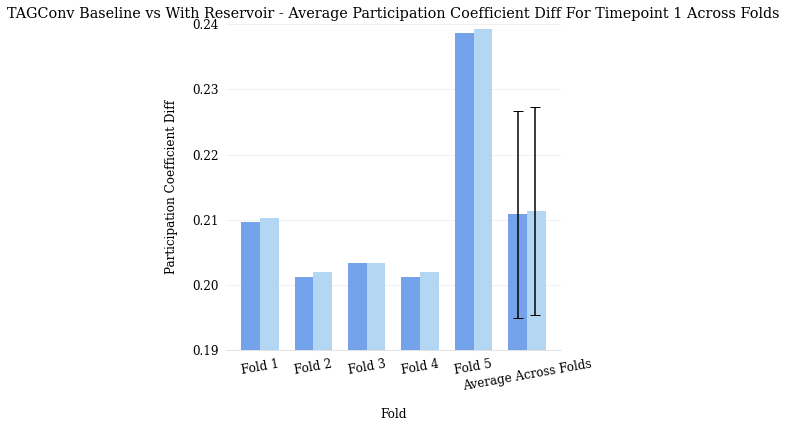

Mean: 0.22829539234862872
Standard Deviation 0.003748488793395938
Baseline Mean: 0.22894915499384463
Baseline Standard Deviation 0.0037460496034310144


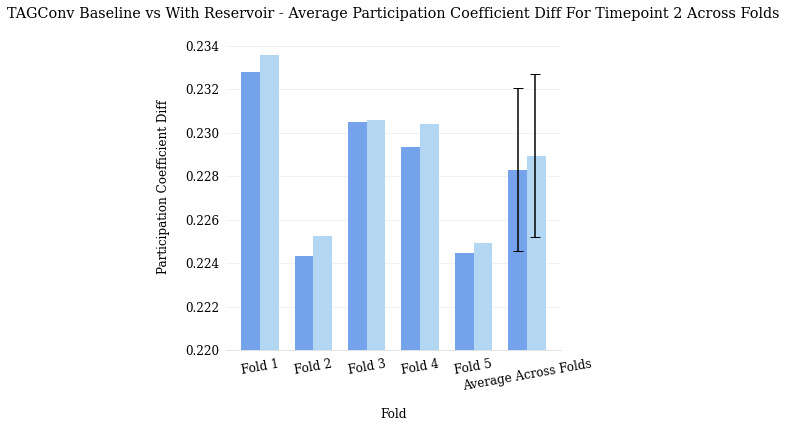

In [35]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.19, 0.24), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.22, 0.2350), palette_nodewise)

Mean: 0.13850253511736896
Standard Deviation 0.011228097184613834
Baseline Mean: 0.14193055797909215
Baseline Standard Deviation 0.01152616510373029


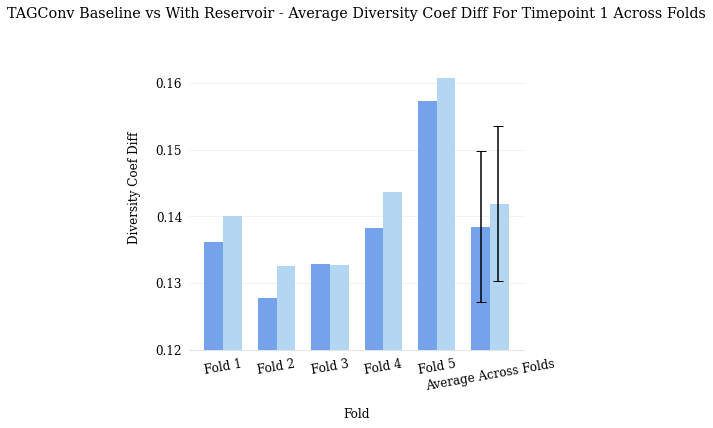

Mean: 0.15491911618128926
Standard Deviation 0.002151719557442483
Baseline Mean: 0.158792137185751
Baseline Standard Deviation 0.003720167145389458


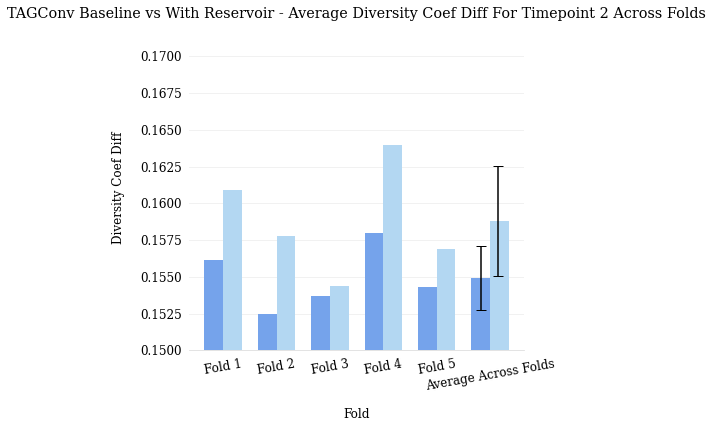

In [53]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.12,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.15,), palette_nodewise)

In [37]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 248.62785714285715
Standard Deviation 11.917334859483583
Baseline Mean: 251.73242857142858
Baseline Standard Deviation 12.96620067124291


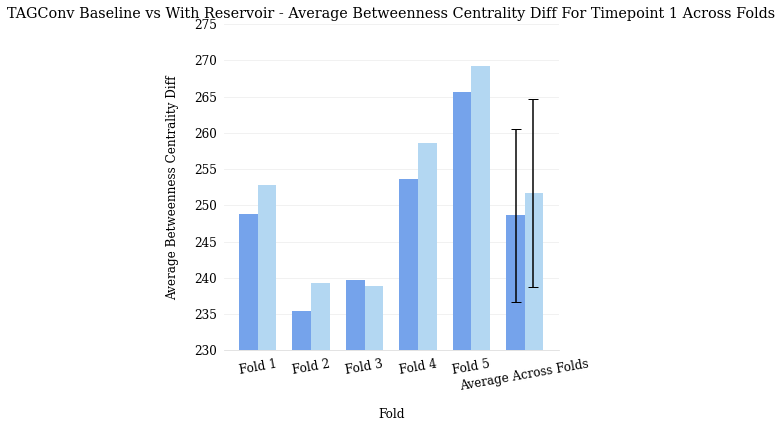

Mean: 264.6931428571429
Standard Deviation 8.233272305538211
Baseline Mean: 267.06014285714286
Baseline Standard Deviation 7.711794594473273


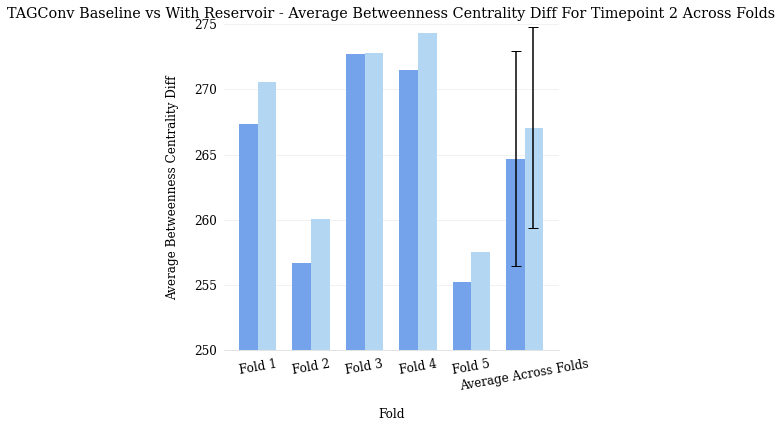

In [38]:
title = 'TAGConv Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (230,275), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (250,275), palette_nodewise)

Mean: 0.003838714442632309
Standard Deviation 0.00019408751175365916
Baseline Mean: 0.0035931291346379818
Baseline Standard Deviation 0.0002902270024514926


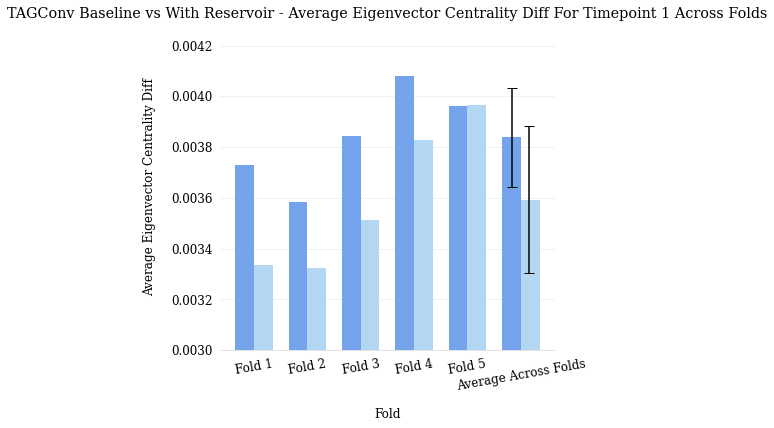

Mean: 0.005265164351904272
Standard Deviation 0.00014818515165744195
Baseline Mean: 0.005198664195910868
Baseline Standard Deviation 0.00017610144029535255


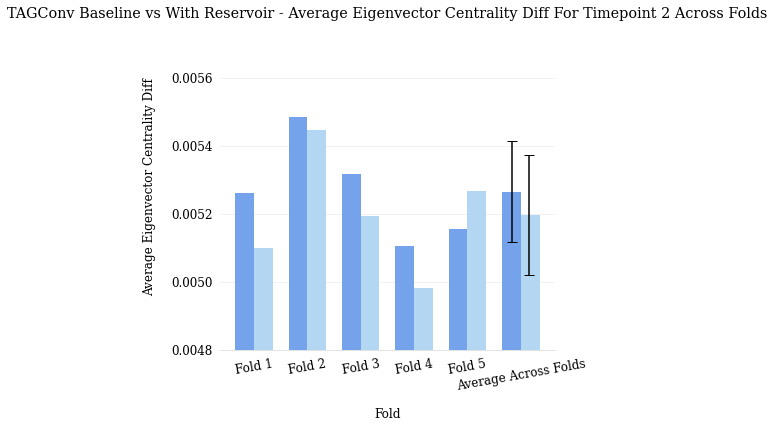

In [54]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.003,), palette_nodewise)
title = 'TAGConv Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0048,), palette_nodewise)

### Efficiency

In [40]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.09514332469002926
Standard Deviation 0.0027970670685402346
Baseline Mean: 0.09842638312515142
Baseline Standard Deviation 0.003167236089229604


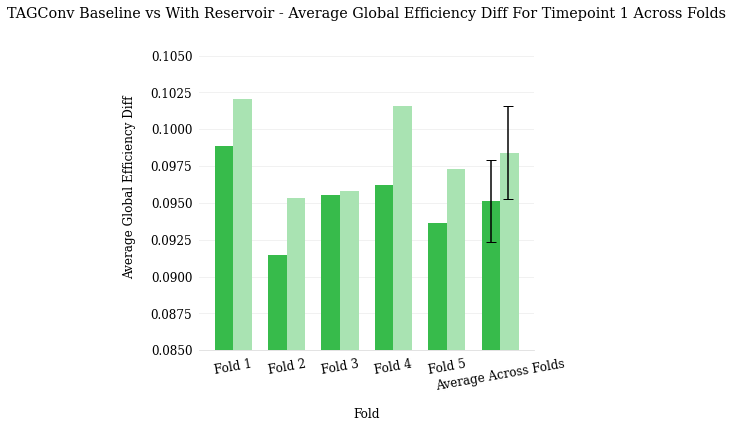

Mean: 0.09067159851776256
Standard Deviation 0.0024453651002095057
Baseline Mean: 0.09458495548530664
Baseline Standard Deviation 0.0024479886984839078


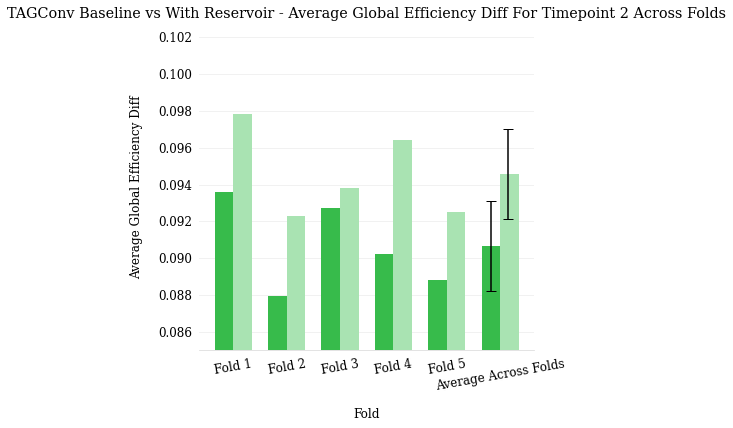

In [55]:
title = 'TAGConv Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.085,), palette_efficiency)
title = 'TAGConv Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.085,), palette_efficiency)

In [42]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.0671463230283739
Standard Deviation 0.0019240472635495313
Baseline Mean: 0.07015953547505112
Baseline Standard Deviation 0.00229760210536942


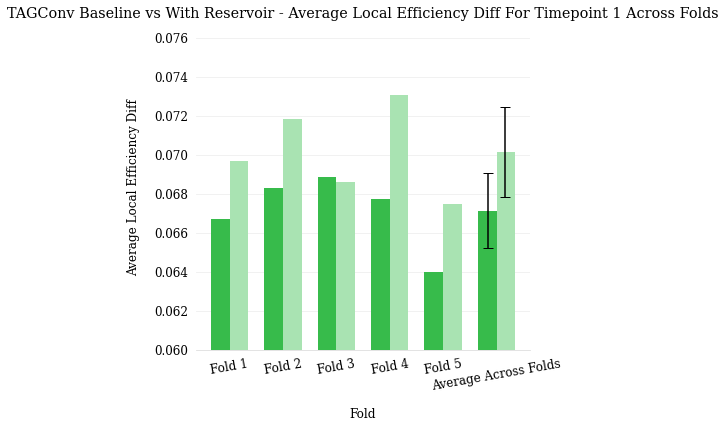

Mean: 0.07365302468920956
Standard Deviation 0.017158058316751216
Baseline Mean: 0.07744486959165932
Baseline Standard Deviation 0.01890065198372154


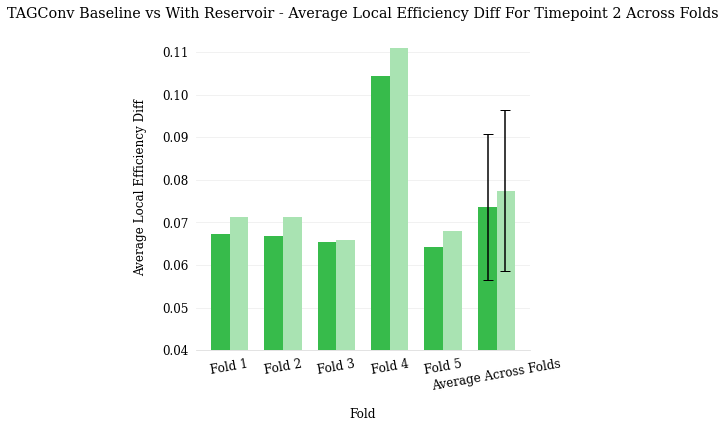

In [57]:
title = 'TAGConv Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.06,), palette_efficiency)
title = 'TAGConv Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.04,), palette_efficiency)

### Modularity

In [44]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.00525026807036699
Standard Deviation 0.0009711672066686845
Baseline Mean: 0.003918439228104984
Baseline Standard Deviation 0.0009896379976941394


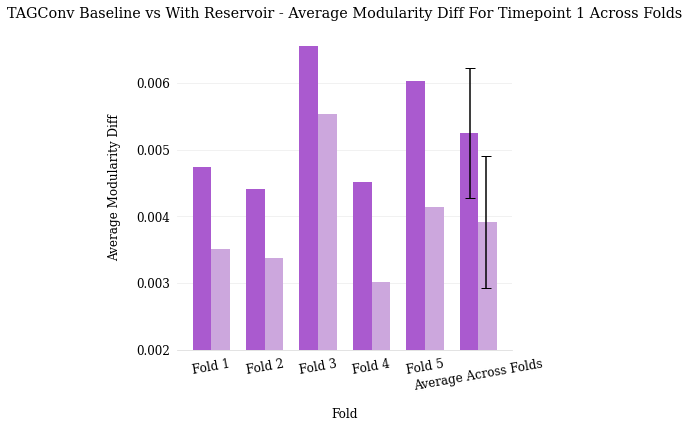

Mean: 0.004027769082687113
Standard Deviation 0.002056206392789494
Baseline Mean: 0.003041014175620088
Baseline Standard Deviation 0.0011855210962631306


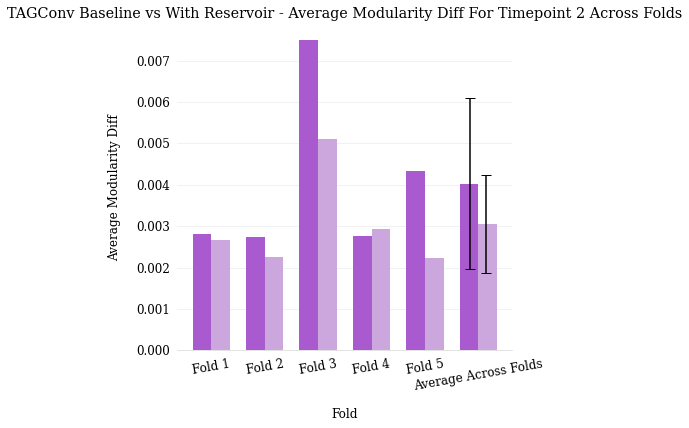

In [58]:
title = 'TAGConv Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0,), palette_global)           

### Density

Mean: 0.04780672268907568
Standard Deviation 0.002660264511941923
Baseline Mean: 0.050546218487394996
Baseline Standard Deviation 0.0027915101246845375


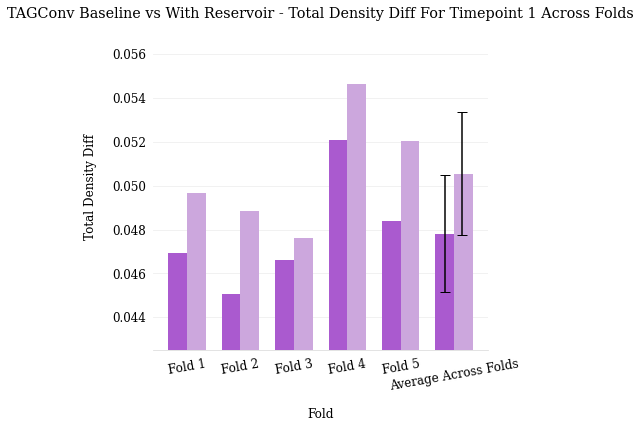

Mean: 0.04996638655462189
Standard Deviation 0.0027311570774509178
Baseline Mean: 0.05410084033613447
Baseline Standard Deviation 0.0022748521564872407


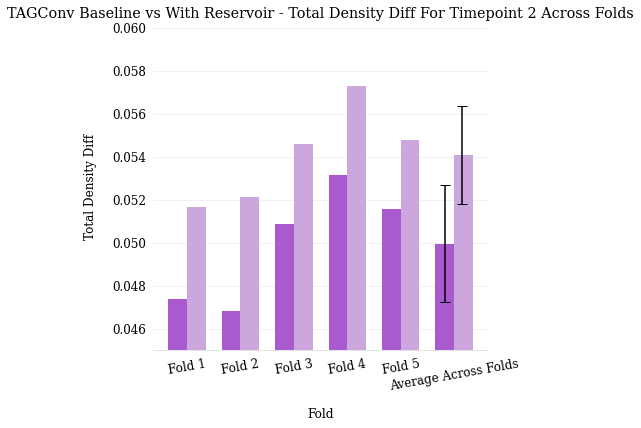

In [59]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'TAGConv Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.0425,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.045,), palette_global)


### Clustering

Mean: 0.009724286230459175
Standard Deviation 0.0014302843616664247
Baseline Mean: 0.011338872129907652
Baseline Standard Deviation 0.0019336507637271975


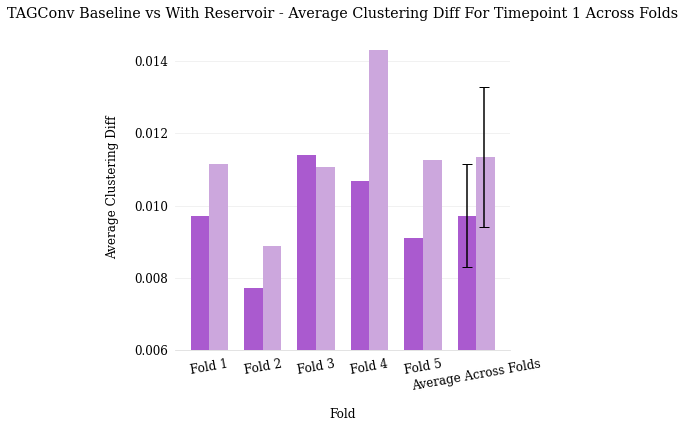

Mean: 0.009851751932155477
Standard Deviation 0.00032593825265488514
Baseline Mean: 0.012602623239240517
Baseline Standard Deviation 0.0016916323851962646


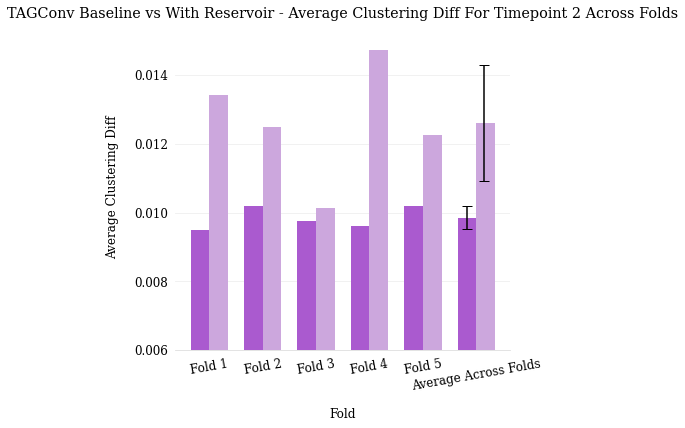

In [60]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'TAGConv Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.006,), palette_global)
title = 'TAGConv Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.006,), palette_global)

## RBGM

In [61]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_rbgm/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

In [62]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_rbgm/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 5, 40, 2)

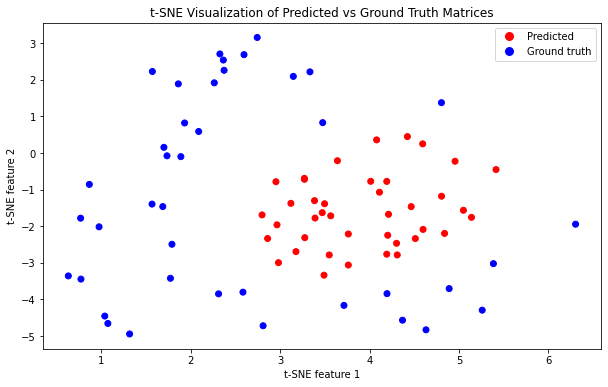

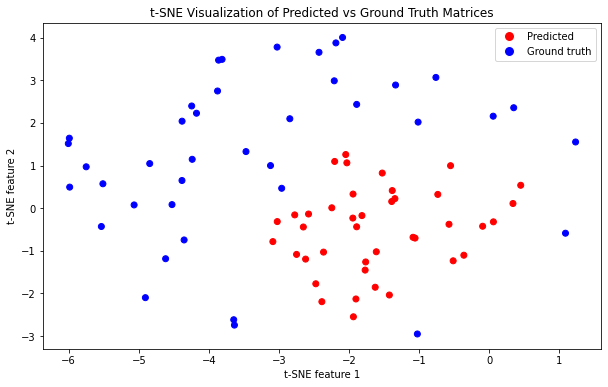

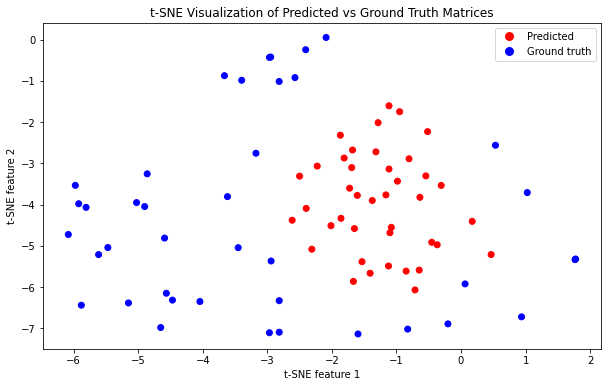

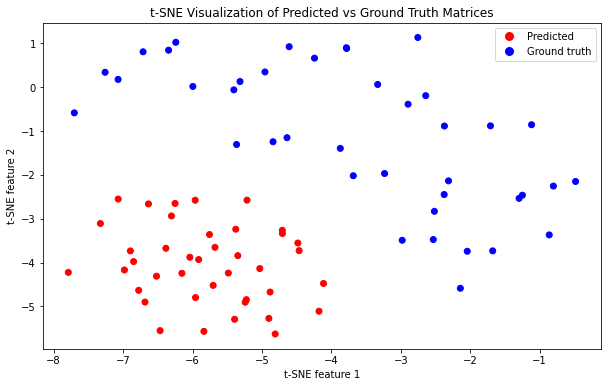

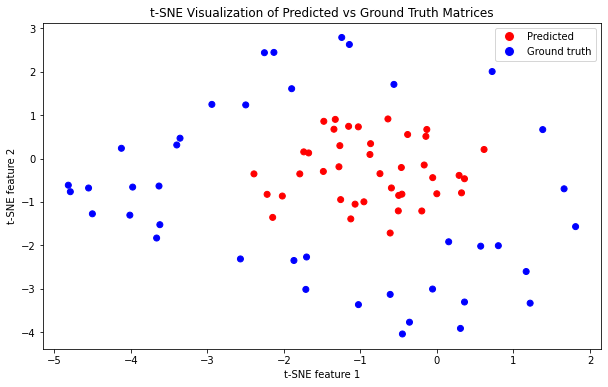

In [53]:
for (original_t1, predicted_t1) in zip(baseline_original_across_all_folds[:,:,0,:,:], baseline_predicted_across_all_folds[:,:,0,:,:]):
    visualization(original_t1, predicted_t1)

Mean: 0.03556392669677734
Standard Deviation 0.0007894472991076636
Baseline Mean: 0.03575670659542084
Baseline Standard Deviation 0.0008746313203369562


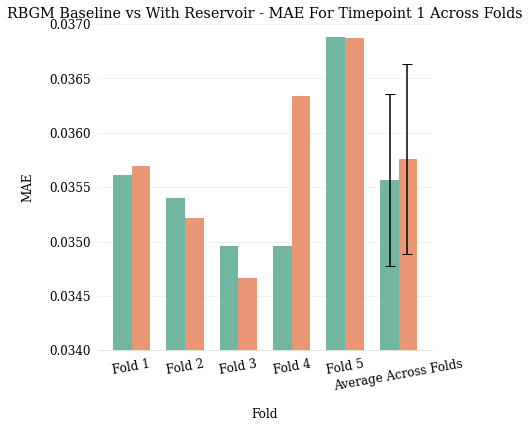

In [57]:
title = 'RBGM Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.034,0.037))

Mean: 0.037283543348312374
Standard Deviation 0.0013468794193967908
Baseline Mean: 0.037480146884918214
Baseline Standard Deviation 0.0015808848603049957


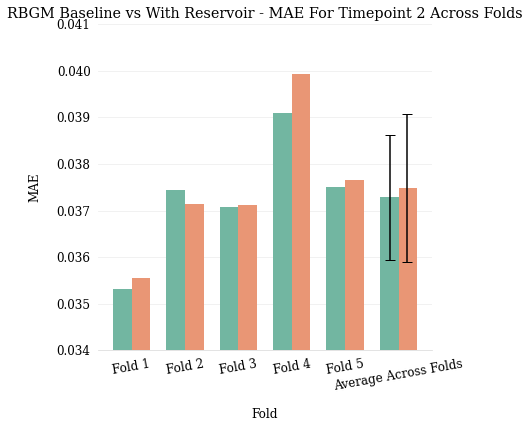

In [58]:
title = 'RBGM Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.034, 0.041))

Mean: 0.24599817030202742
Standard Deviation 0.03966095139702504
Baseline Mean: 0.5409859102743158
Baseline Standard Deviation 0.10082653225240873


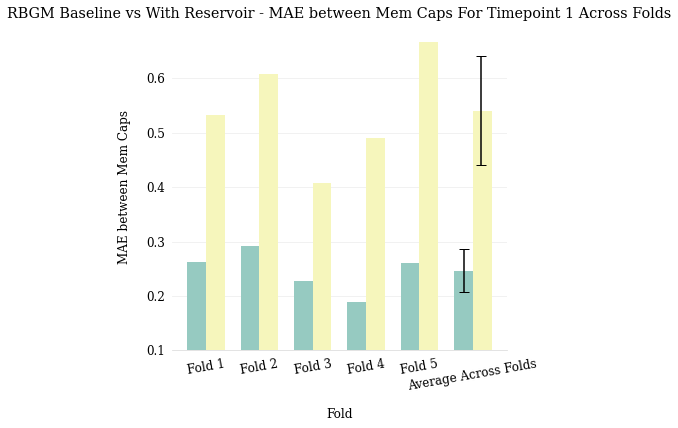

In [59]:
title = 'RBGM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.1,), 'Set3')

Mean: 0.6273956937096165
Standard Deviation 0.08408076723549805
Baseline Mean: 0.8663120905381156
Baseline Standard Deviation 0.08931033383330104


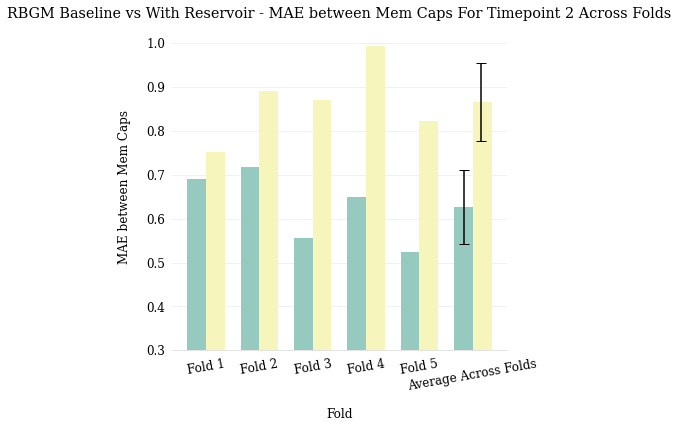

In [60]:
title = 'RBGM Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.3,), 'Set3')

In [92]:
baseline_rbgm_times = [334.50, 335.39, 336.54, 335.92, 334.47]
baseline_rbgm_memory_usage_MB = [2585.46, 2585.46, 2591.21, 2591.21, 2591.21]

In [93]:
reservoir_rbgm_times = [1865.89, 1820.70, 1817.89, 1821.55, 1819.30]
reservoir_rbgm_memory_usage_MB = [2621.08, 2621.08, 2621.08, 2621.08, 2621.08]

In [94]:
print_mean_std(reservoir_rbgm_times, baseline_rbgm_times)

Mean: 1829.066
Standard Deviation 20.632286106973254
Baseline Mean: 335.36400000000003
Baseline Standard Deviation 0.899794420965147


(1829.066, 335.36400000000003, 20.632286106973254, 0.899794420965147)

In [95]:
print_mean_std(reservoir_rbgm_memory_usage_MB, baseline_rbgm_memory_usage_MB)

Mean: 2621.08
Standard Deviation 0.0
Baseline Mean: 2588.91
Baseline Standard Deviation 3.1494047056547054


(2621.08, 2588.91, 0.0, 3.1494047056547054)

### Node Strength

Mean: 0.3533355005948058
Standard Deviation 0.022655000608312943
Baseline Mean: 0.33570185898322163
Baseline Standard Deviation 0.022117426929977348


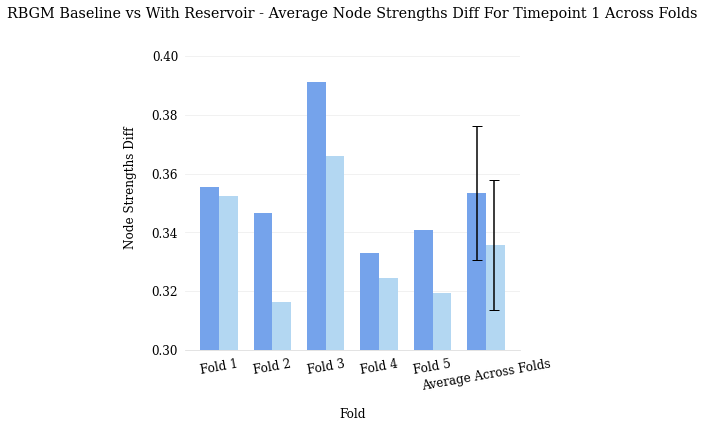

Mean: 0.4770324574061751
Standard Deviation 0.11141715936204102
Baseline Mean: 0.44562531908426894
Baseline Standard Deviation 0.07517048943349296


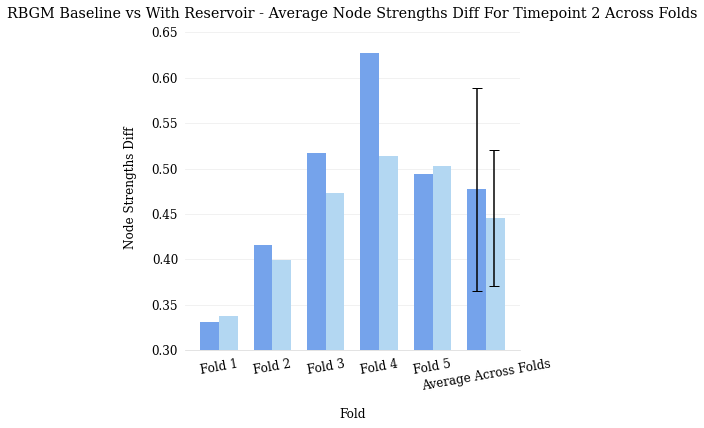

In [77]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.3,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.3,), palette_nodewise)

### Centrality

Mean: 0.21007425442025834
Standard Deviation 0.01593379893677193
Baseline Mean: 0.21021895375873836
Baseline Standard Deviation 0.01611217019473069


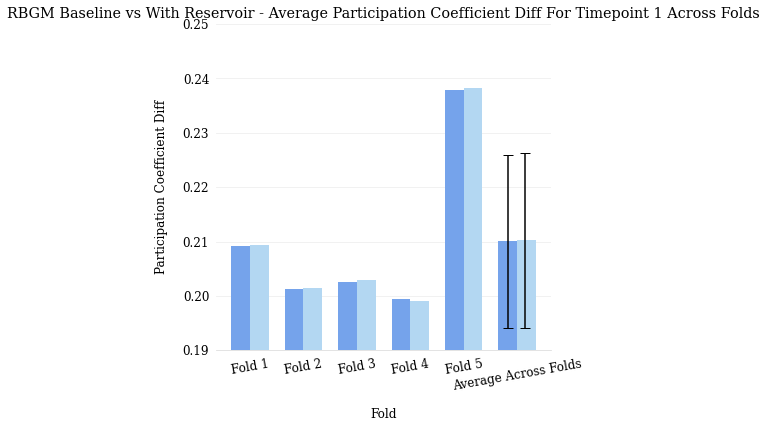

Mean: 0.22683834682520615
Standard Deviation 0.004009486113566362
Baseline Mean: 0.22710566029975168
Baseline Standard Deviation 0.004011145108678589


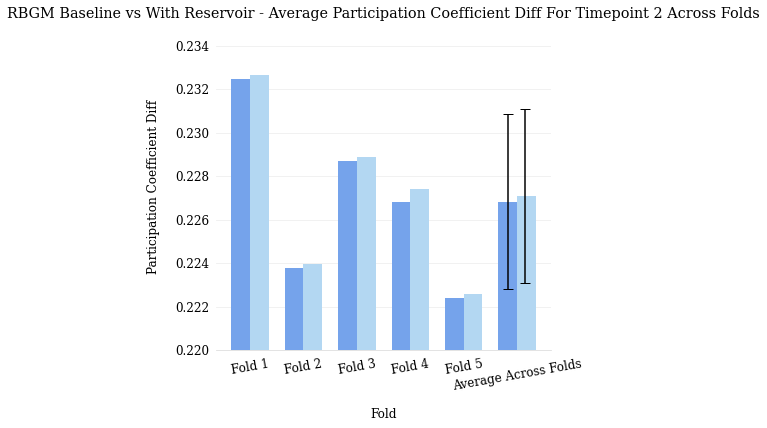

In [64]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.19, 0.25), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.22, 0.235), palette_nodewise)

Mean: 0.13204503049906618
Standard Deviation 0.010298496533284539
Baseline Mean: 0.13302810578876995
Baseline Standard Deviation 0.011325205766009556


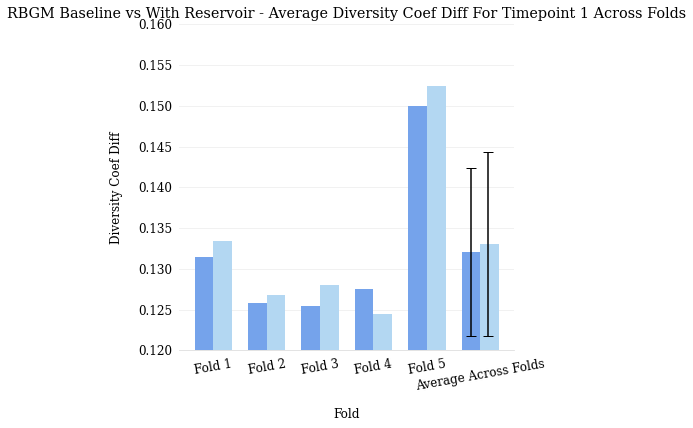

Mean: 0.14389843298823007
Standard Deviation 0.004254221070842224
Baseline Mean: 0.14569495593862666
Baseline Standard Deviation 0.004511388074236801


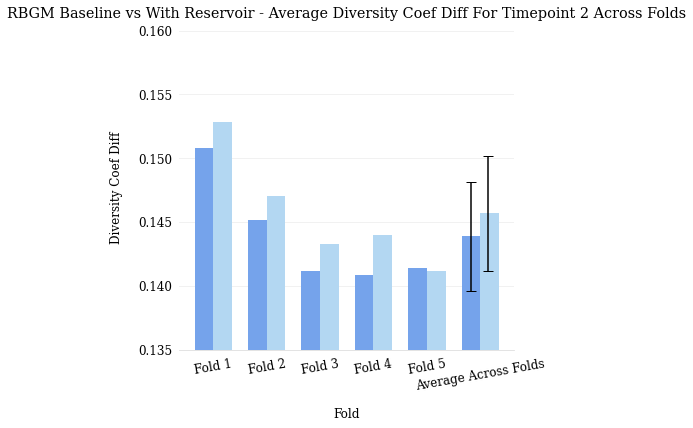

In [78]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.12,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.135,), palette_nodewise)

In [66]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 238.04999999999998
Standard Deviation 12.542401879144201
Baseline Mean: 241.01457142857146
Baseline Standard Deviation 11.350505356006636


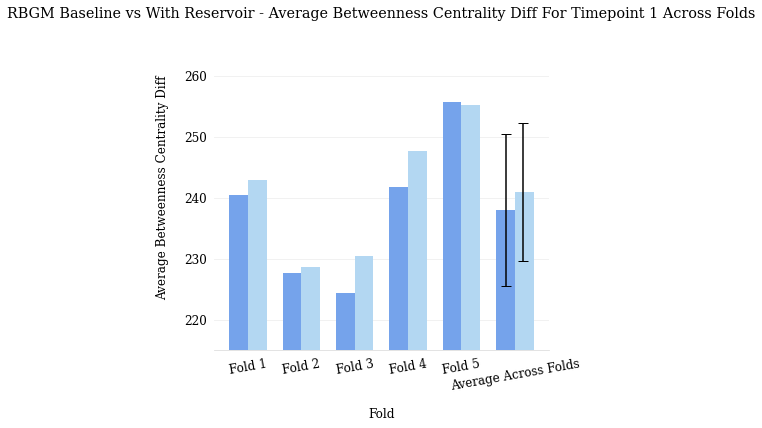

Mean: 250.32114285714286
Standard Deviation 6.491237374573609
Baseline Mean: 255.18971428571427
Baseline Standard Deviation 10.30699433859935


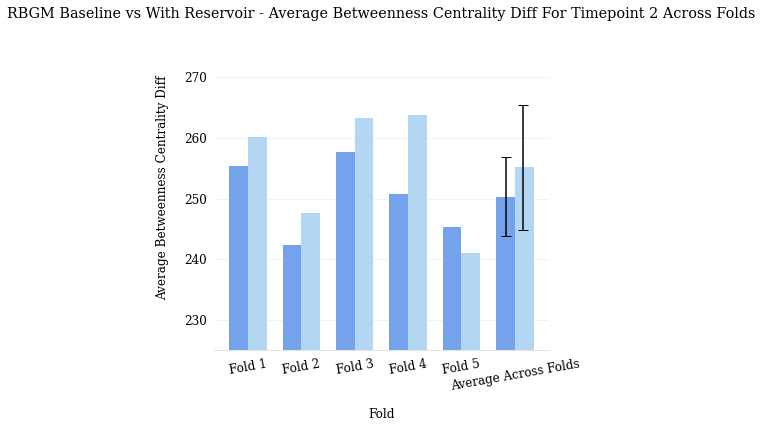

In [67]:
title = 'RBGM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (215,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (225,), palette_nodewise)

Mean: 0.004336865907056731
Standard Deviation 0.00027175069587098325
Baseline Mean: 0.004162194398366573
Baseline Standard Deviation 0.0002373456958677362


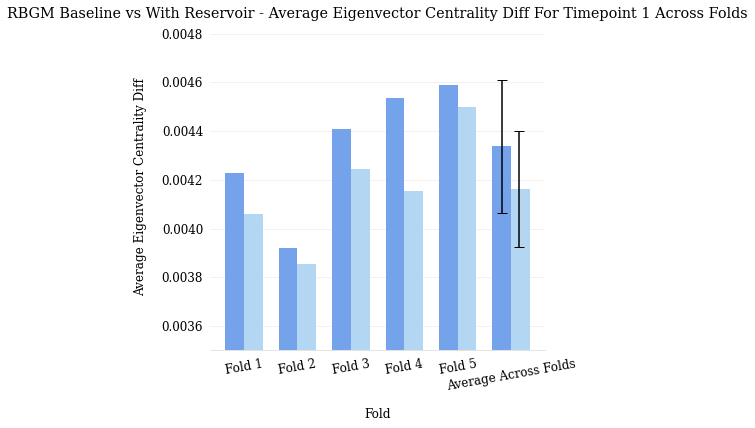

Mean: 0.004957085487246724
Standard Deviation 0.0003891559597032688
Baseline Mean: 0.005096576357326072
Baseline Standard Deviation 0.0002154877925575508


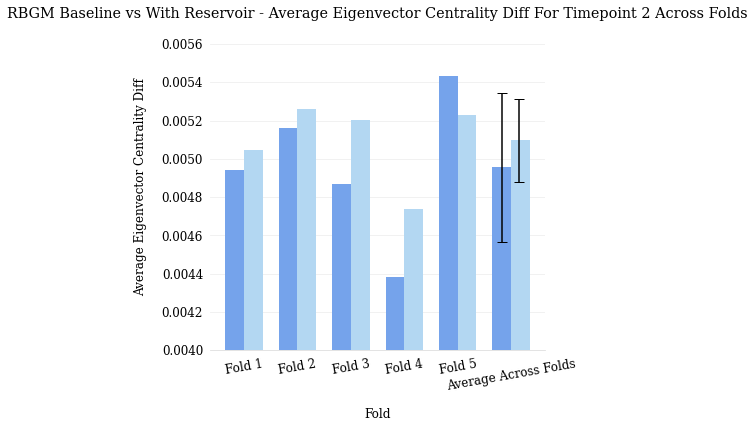

In [79]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.0035,), palette_nodewise)
title = 'RBGM Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.004,), palette_nodewise)

### Efficiency

In [69]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.09684016504952246
Standard Deviation 0.0017383024864309957
Baseline Mean: 0.09892902247499716
Baseline Standard Deviation 0.0025272855182463146


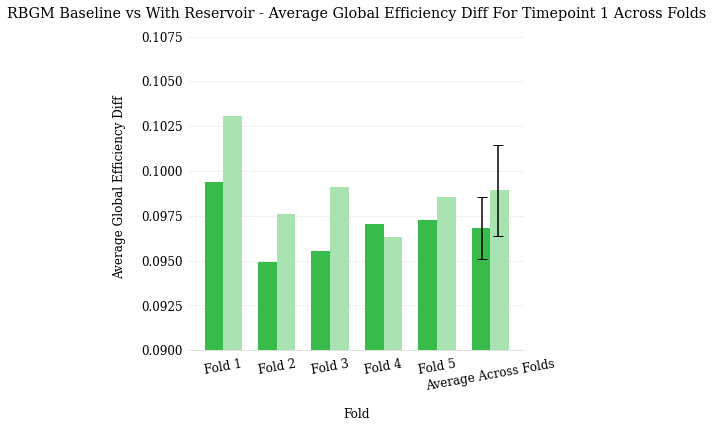

Mean: 0.08983284142046911
Standard Deviation 0.0027540068544582644
Baseline Mean: 0.0941992419144336
Baseline Standard Deviation 0.0030375451287820553


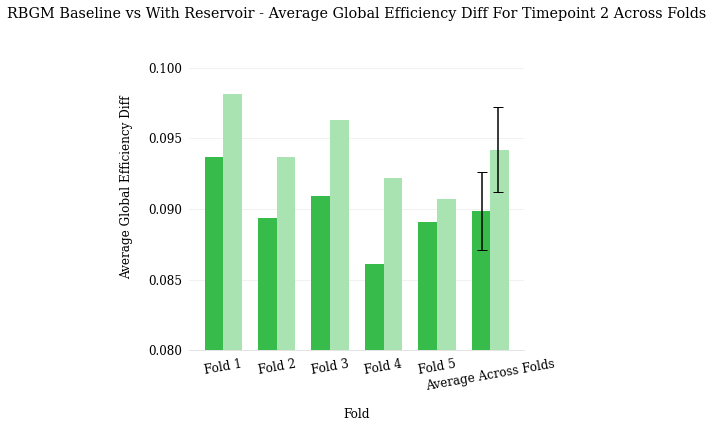

In [80]:
title = 'RBGM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.09,), palette_efficiency)
title = 'RBGM Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.08,), palette_efficiency)

In [71]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.06977699373808023
Standard Deviation 0.0019262949935004937
Baseline Mean: 0.07188217116090947
Baseline Standard Deviation 0.0024554048186576725


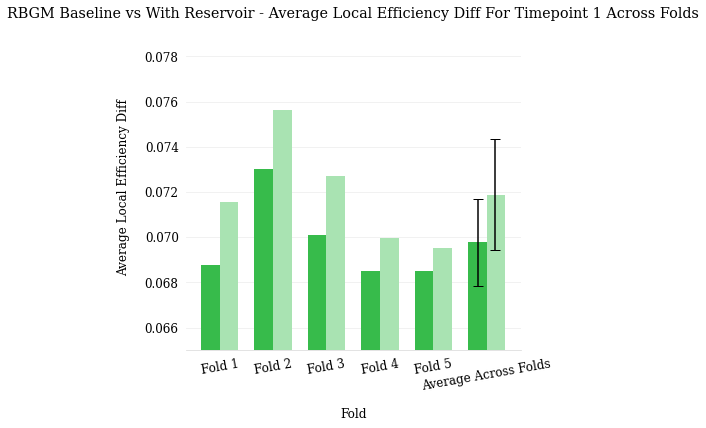

Mean: 0.07198654410733264
Standard Deviation 0.015187331730955626
Baseline Mean: 0.07635305026553048
Baseline Standard Deviation 0.017773925687810416


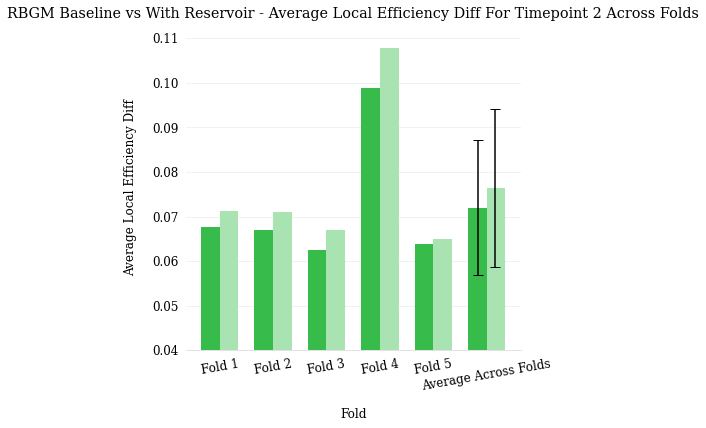

In [81]:
title = 'RBGM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.065,), palette_efficiency)
title = 'RBGM Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.04,), palette_efficiency)

### Modularity

In [73]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.008058501276727578
Standard Deviation 0.003126748449843592
Baseline Mean: 0.00764781847173983
Baseline Standard Deviation 0.0021477752850612873


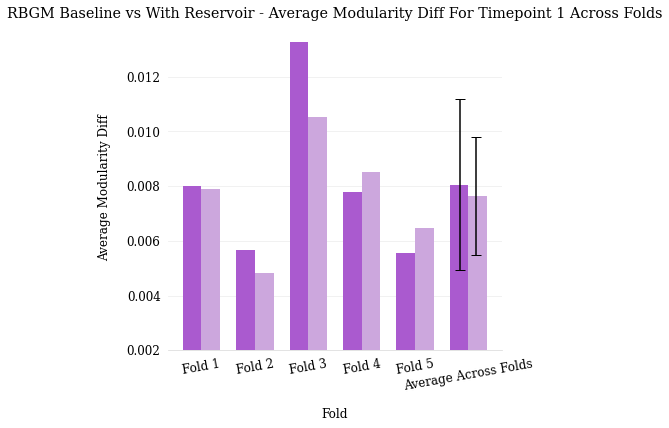

Mean: 0.0041346264938450445
Standard Deviation 0.0007383332457917032
Baseline Mean: 0.004138844435527478
Baseline Standard Deviation 0.0011361389617796122


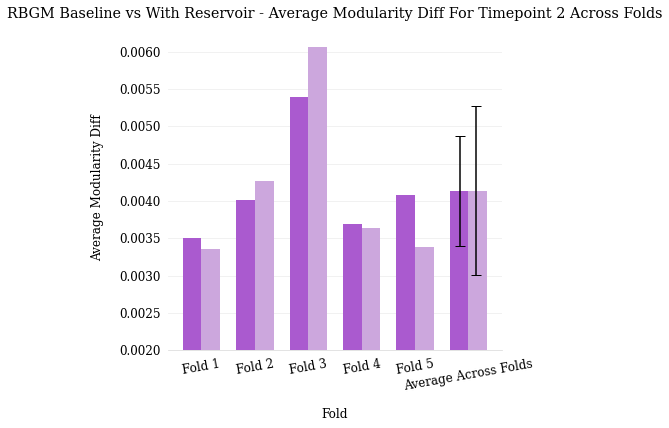

In [82]:
title = 'RBGM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.002,), palette_global)           

### Density

Mean: 0.04387394957983198
Standard Deviation 0.001426221497787549
Baseline Mean: 0.04595798319327735
Baseline Standard Deviation 0.002982512645754353


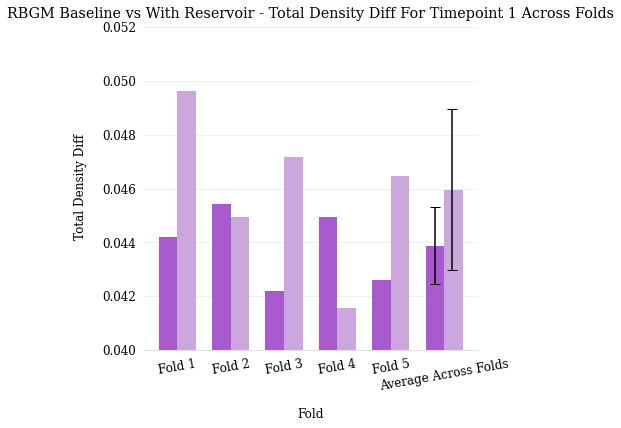

Mean: 0.03807563025210088
Standard Deviation 0.0028499352984626596
Baseline Mean: 0.042168067226890794
Baseline Standard Deviation 0.004072662004978235


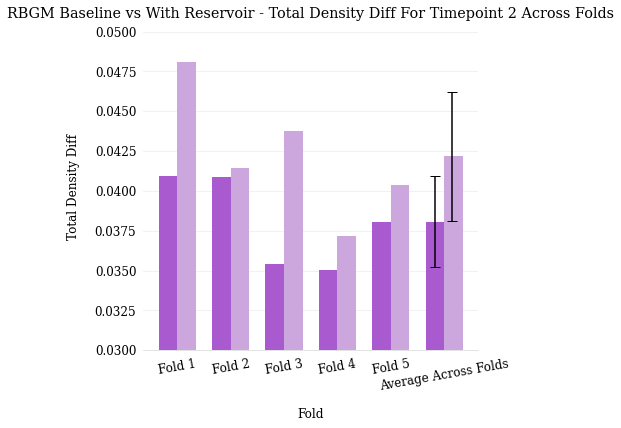

In [83]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'RBGM Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.04,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.03,), palette_global)


### Clustering

Mean: 0.011189404823730301
Standard Deviation 0.0009595358504123994
Baseline Mean: 0.01229250017148765
Baseline Standard Deviation 0.001168888517156604


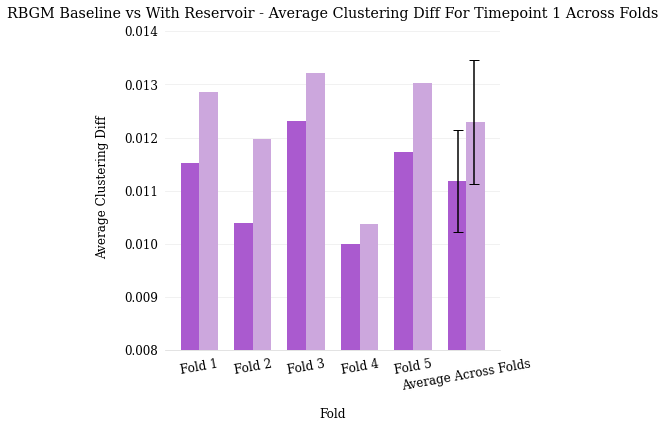

Mean: 0.01272497391987875
Standard Deviation 0.00116747443392336
Baseline Mean: 0.014570770376275887
Baseline Standard Deviation 0.0009661144179428779


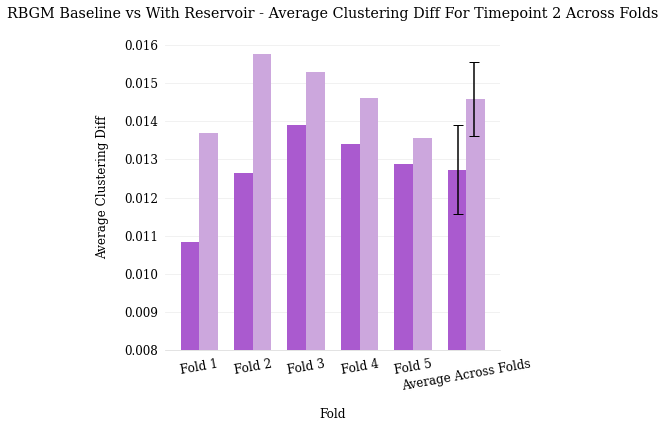

In [84]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'RBGM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.008,), palette_global)
title = 'RBGM Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.008,), palette_global)

## Identity

In [57]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_identity/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

In [59]:
print_mean_std(mae_across_all_folds[:, 0],mae_across_all_folds[:, 1])

Mean: 0.03955052375793457
Standard Deviation 0.0012180624609073303
Baseline Mean: 0.03977079749107361
Baseline Standard Deviation 0.0013439372964221476


(0.03955052375793457,
 0.03977079749107361,
 0.0012180624609073303,
 0.0013439372964221476)

In [60]:
print_mean_std(mem_cap_across_all_folds[:, 0],mem_cap_across_all_folds[:, 1])

Mean: 0.22679966999337942
Standard Deviation 0.03136762886187115
Baseline Mean: 0.241835319662582
Baseline Standard Deviation 0.02940784134524104


(0.22679966999337942,
 0.241835319662582,
 0.03136762886187115,
 0.02940784134524104)

# GConvGRU

In [26]:
file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/reservoir_gconvGRU_language/'
mae_across_all_folds, mem_cap_across_all_folds,\
predicted_across_all_folds, original_across_all_folds = load_test_results(file_path, 5, 40, 2)

In [27]:
baseline_file_path = '/vol/bitbucket/sx420/4D-FedGNN-Plus/results/baseline_gconvGRU_language/'
baseline_mae_across_all_folds, baseline_mem_cap_across_all_folds,\
baseline_predicted_across_all_folds, baseline_original_across_all_folds = load_test_results(baseline_file_path, 5, 40, 2)

## MAE

Mean: 0.032113232016563416
Standard Deviation 0.0011395891736944355
Baseline Mean: 0.03226362645626068
Baseline Standard Deviation 0.0010874907242563153


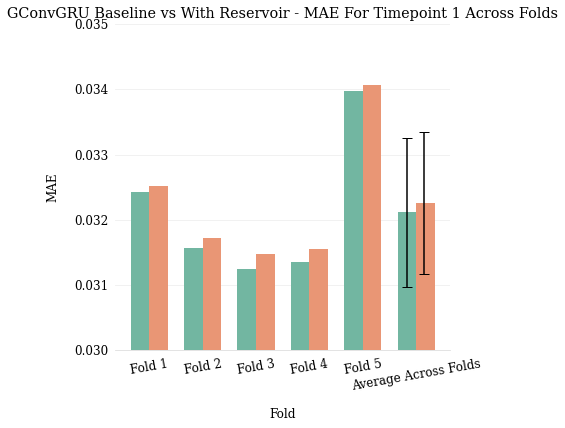

In [29]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 1 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 0, (0.030, 0.035))

Mean: 0.03329812049865723
Standard Deviation 0.0005403191481421134
Baseline Mean: 0.03351874589920044
Baseline Standard Deviation 0.0006100425630249917


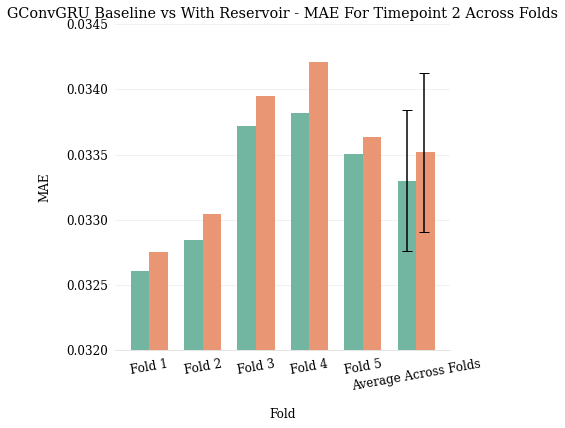

In [32]:
title = 'GConvGRU Baseline vs With Reservoir - MAE For Timepoint 2 Across Folds'
plot_comparison(mae_across_all_folds, baseline_mae_across_all_folds, title, 'MAE', 1, (0.032, 0.0345))

## MAE between Mem Caps

Mean: 0.7326463245686274
Standard Deviation 0.05481819167800008
Baseline Mean: 0.9296885854339746
Baseline Standard Deviation 0.08759416774960528


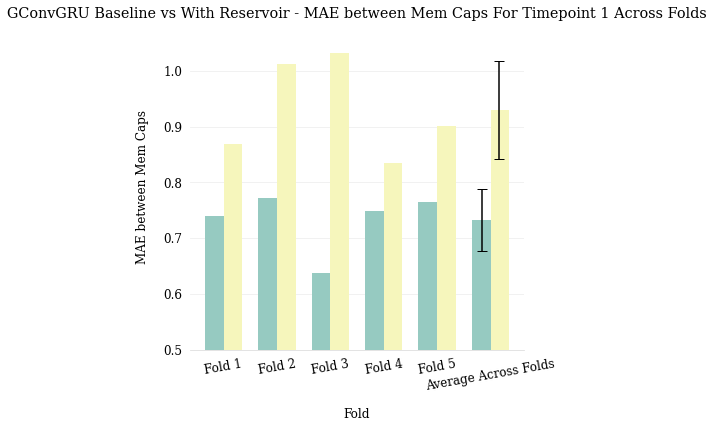

In [33]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 1 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 0, (0.5,), 'Set3')

Mean: 0.8003318704567115
Standard Deviation 0.1538870863996864
Baseline Mean: 1.0041022820602232
Baseline Standard Deviation 0.21589713896288268


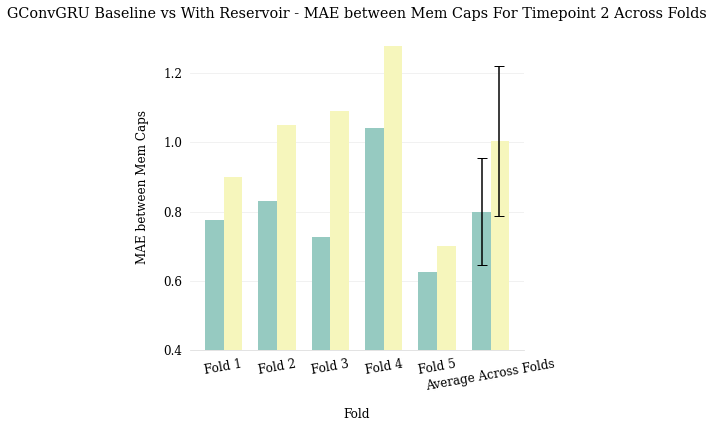

In [35]:
title = 'GConvGRU Baseline vs With Reservoir - MAE between Mem Caps For Timepoint 2 Across Folds'
plot_comparison(mem_cap_across_all_folds, baseline_mem_cap_across_all_folds, title, 'MAE between Mem Caps', 1, (0.4,), 'Set3')

### Node Strength

Mean: 0.2768503008159736
Standard Deviation 0.03325690911720399
Baseline Mean: 0.28158422139937
Baseline Standard Deviation 0.027738645942874292


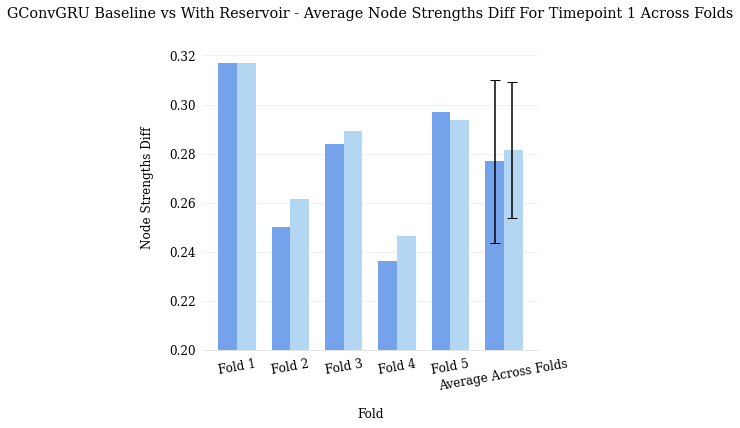

Mean: 0.3497839760491119
Standard Deviation 0.037636335132321556
Baseline Mean: 0.36169032880224555
Baseline Standard Deviation 0.047573222095758726


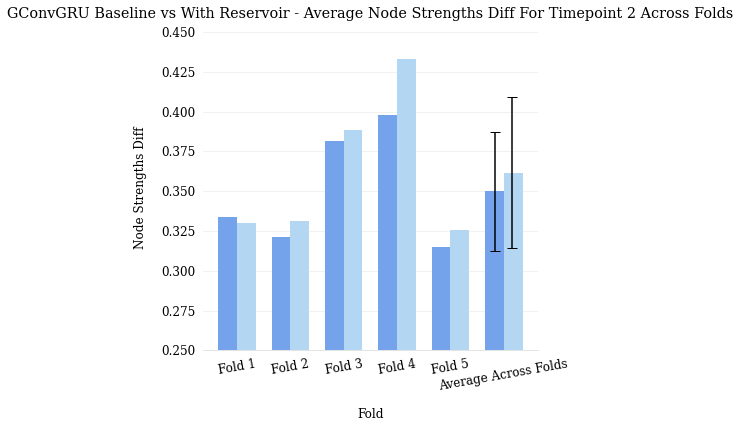

In [63]:
reservoir_node_strength_diff = get_diffs_across_folds(node_strength_diff, predicted_across_all_folds, original_across_all_folds)
baseline_node_strength_diff = get_diffs_across_folds(node_strength_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 0, (0.2,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Node Strengths Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_node_strength_diff, baseline_node_strength_diff, title, 'Node Strengths Diff', 1, (0.25,), palette_nodewise)

### Centrality

Mean: 0.21120223187960216
Standard Deviation 0.016085011474952265
Baseline Mean: 0.2112227826116049
Baseline Standard Deviation 0.016091735971732146


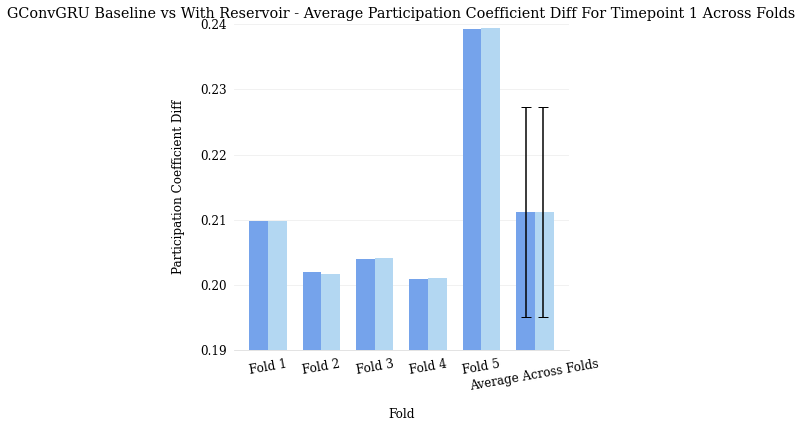

Mean: 0.22683476345294362
Standard Deviation 0.0036417808151263963
Baseline Mean: 0.2268306731974081
Baseline Standard Deviation 0.0037828892352144115


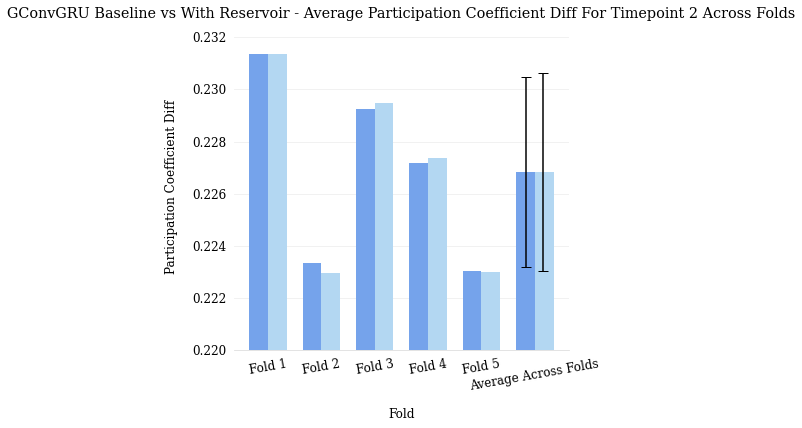

In [53]:
reservoir_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_participation_coef_diff = get_diffs_across_folds(participation_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 0, (0.19, 0.24), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Participation Coefficient Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_participation_coef_diff, baseline_participation_coef_diff, title, 'Participation Coefficient Diff', 1, (0.22, 0.2325), palette_nodewise)

Mean: 0.1411070940371797
Standard Deviation 0.011161630364207292
Baseline Mean: 0.1412656502218324
Baseline Standard Deviation 0.011455095409720435


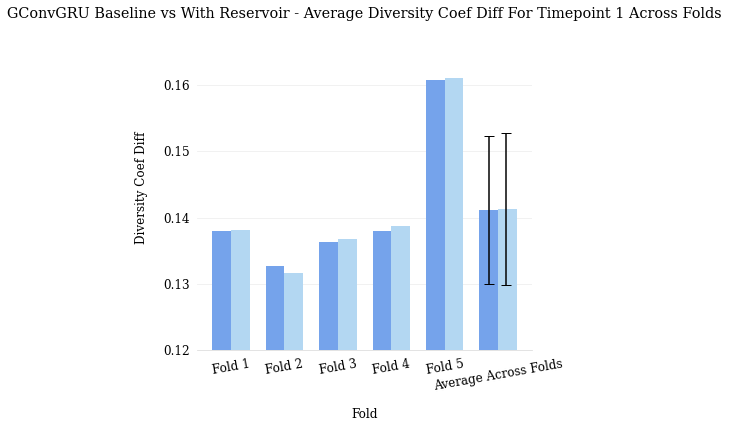

Mean: 0.14852161667401734
Standard Deviation 0.001024331464617863
Baseline Mean: 0.14855627224032897
Baseline Standard Deviation 0.0013563099600399431


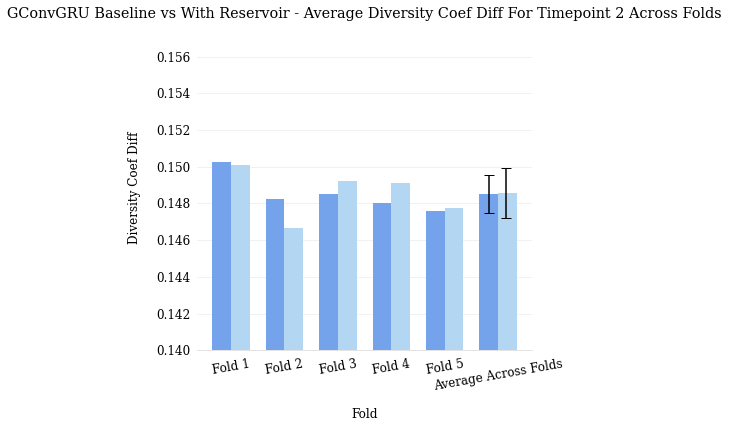

In [54]:
reservoir_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, predicted_across_all_folds, original_across_all_folds)
baseline_diversity_coef_diff = get_diffs_across_folds(diversity_coef_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 0, (0.12,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Diversity Coef Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_diversity_coef_diff, baseline_diversity_coef_diff, title, 'Diversity Coef Diff', 1, (0.14,), palette_nodewise)

Mean: 252.2012857142857
Standard Deviation 12.117453073133442
Baseline Mean: 253.3404285714286
Baseline Standard Deviation 12.223135574201352


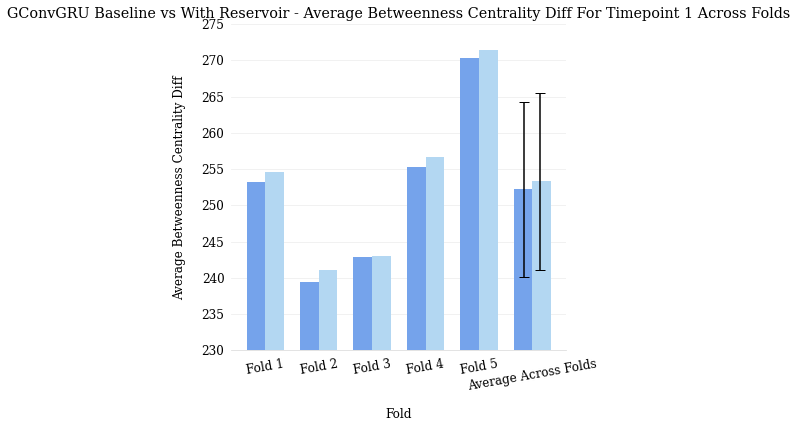

Mean: 264.5212857142857
Standard Deviation 7.550372531017425
Baseline Mean: 264.48314285714287
Baseline Standard Deviation 7.499622415665401


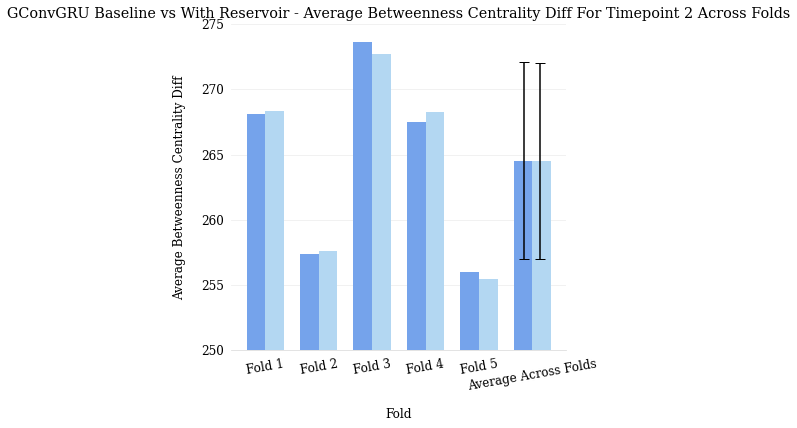

In [68]:
reservoir_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_betweeness_centrality_diff = get_diffs_across_folds(betweeness_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 0, (230,275), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Betweenness Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_betweeness_centrality_diff, baseline_betweeness_centrality_diff, title, 'Average Betweenness Centrality Diff', 1, (250,275), palette_nodewise)

Mean: 0.003386896783346944
Standard Deviation 0.0003059723118002223
Baseline Mean: 0.0034374210910744895
Baseline Standard Deviation 0.00034257580113883465


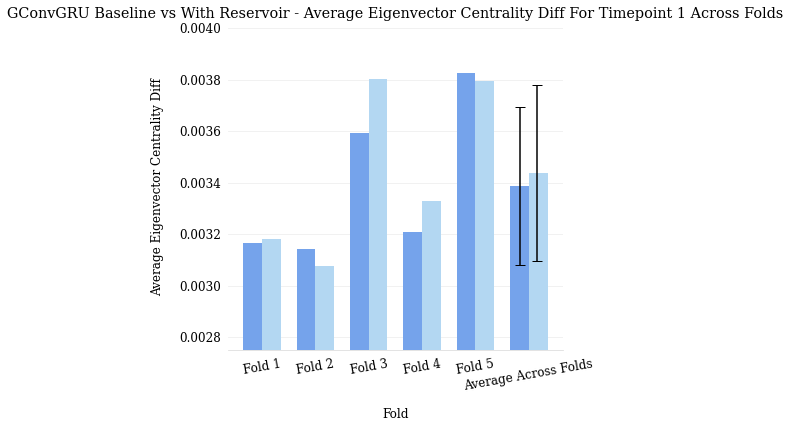

Mean: 0.004395675023661188
Standard Deviation 0.00042598432380545355
Baseline Mean: 0.004451549190834895
Baseline Standard Deviation 0.0003760116584103497


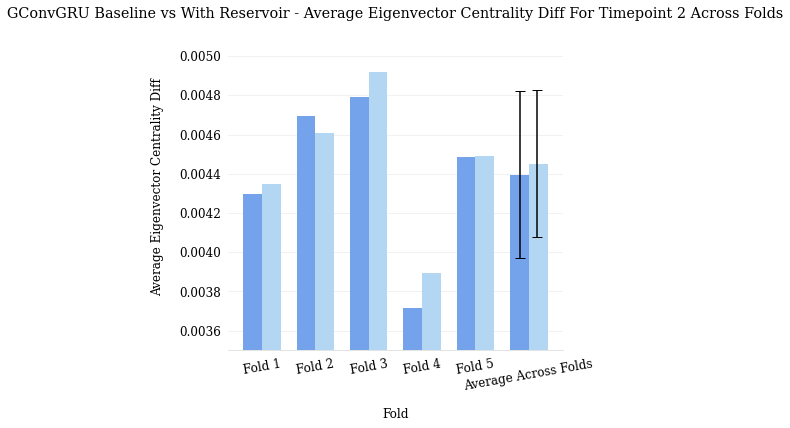

In [55]:
reservoir_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, predicted_across_all_folds, original_across_all_folds)
baseline_eigenvector_centrality_diff = get_diffs_across_folds(eigenvector_centrality_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 0, (0.00275,), palette_nodewise)
title = 'GConvGRU Baseline vs With Reservoir - Average Eigenvector Centrality Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_eigenvector_centrality_diff, baseline_eigenvector_centrality_diff, title, 'Average Eigenvector Centrality Diff', 1, (0.0035,), palette_nodewise)

### Efficiency

In [58]:
reservoir_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_global_efficiency_diff = get_diffs_across_folds(global_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.10083784972413336
Standard Deviation 0.002308161840207998
Baseline Mean: 0.100396898977352
Baseline Standard Deviation 0.0018792210847451993


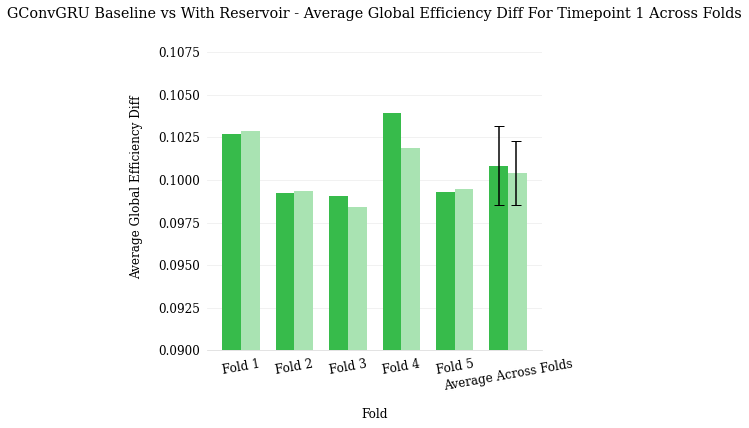

Mean: 0.09678117174833119
Standard Deviation 0.0015369684481134416
Baseline Mean: 0.09609380950172003
Baseline Standard Deviation 0.0010210323090444598


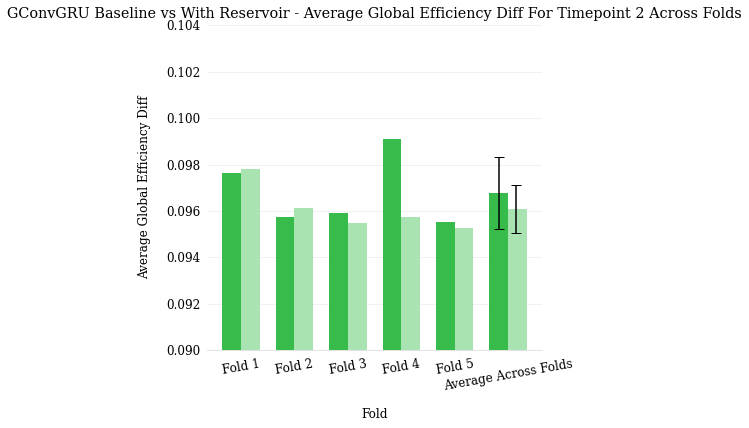

In [59]:
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 0, (0.09,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Global Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_global_efficiency_diff, baseline_global_efficiency_diff, title, 'Average Global Efficiency Diff', 1, (0.09,), palette_efficiency)

In [60]:
reservoir_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, predicted_across_all_folds, original_across_all_folds)
baseline_local_efficiency_diff = get_diffs_across_folds(local_efficiency_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.07001902955166323
Standard Deviation 0.0023130892627449555
Baseline Mean: 0.0696125328179005
Baseline Standard Deviation 0.0022157110438339516


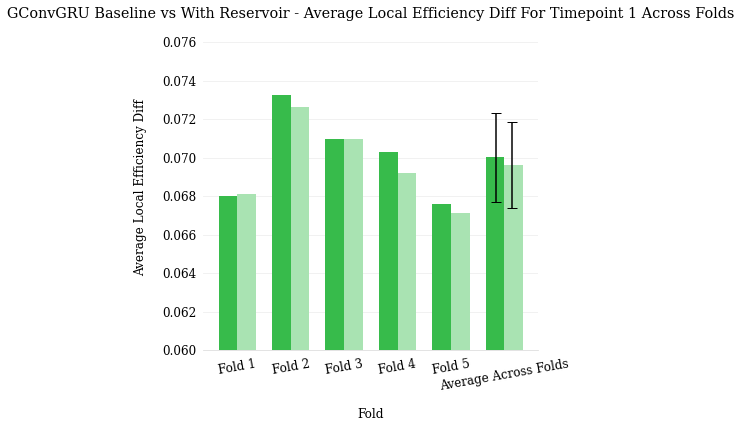

Mean: 0.0735681173332829
Standard Deviation 0.016936671137990925
Baseline Mean: 0.07282053011366806
Baseline Standard Deviation 0.016399648366105402


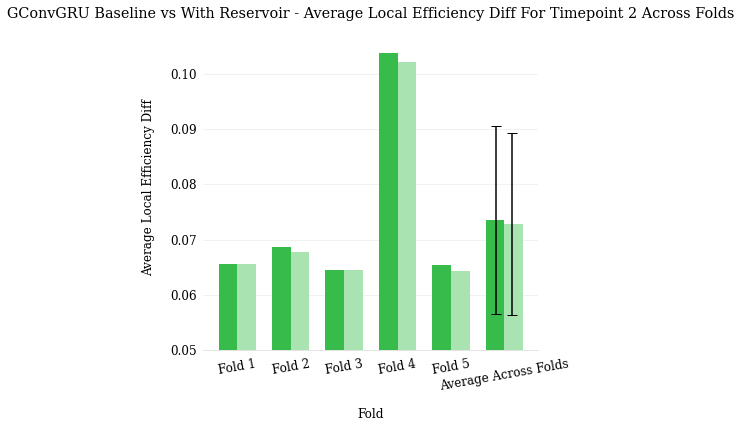

In [61]:
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 0, (0.06,), palette_efficiency)
title = 'GConvGRU Baseline vs With Reservoir - Average Local Efficiency Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_local_efficiency_diff, baseline_local_efficiency_diff, title, 'Average Local Efficiency Diff', 1, (0.05,), palette_efficiency)

### Modularity

In [78]:
reservoir_modularity_diff = get_diffs_across_folds(modularity_diff, predicted_across_all_folds, original_across_all_folds)
baseline_modularity_diff = get_diffs_across_folds(modularity_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

Mean: 0.003078004485841743
Standard Deviation 0.00022939381944460762
Baseline Mean: 0.003558519228099451
Baseline Standard Deviation 0.001048098948312037


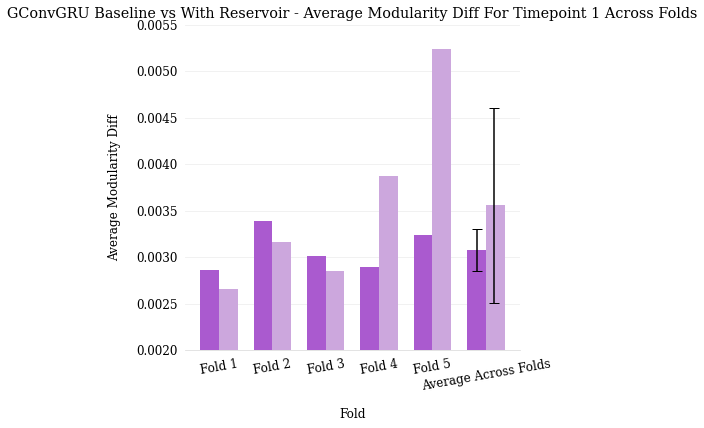

Mean: 0.001531314873044023
Standard Deviation 0.00023026488155372755
Baseline Mean: 0.002287495509589321
Baseline Standard Deviation 0.0008413466350191078


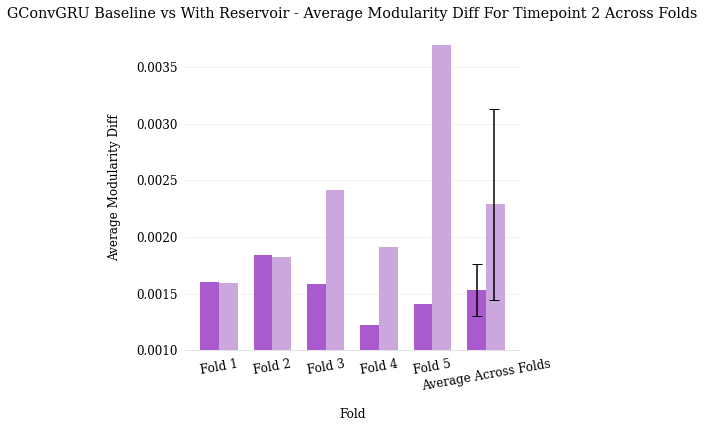

In [82]:
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 0, (0.002,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Modularity Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_modularity_diff, baseline_modularity_diff, title, 'Average Modularity Diff', 1, (0.001,), palette_global)           

### Density

Mean: 0.04626890756302527
Standard Deviation 0.0015663311022751994
Baseline Mean: 0.04779831932773115
Baseline Standard Deviation 0.0035886387115045206


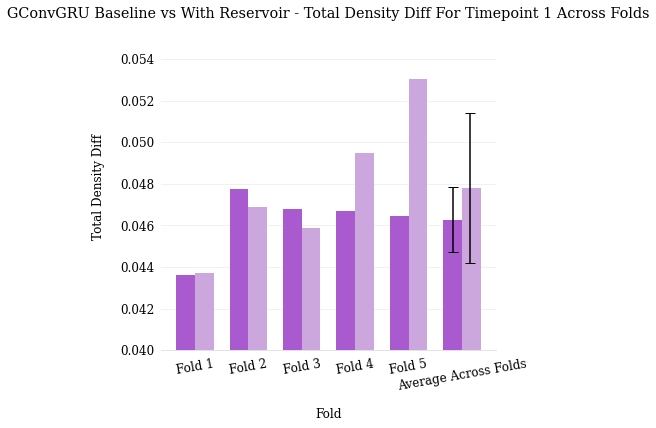

Mean: 0.043025210084033684
Standard Deviation 0.0009709428578396047
Baseline Mean: 0.044588235294117706
Baseline Standard Deviation 0.0022180337580509557


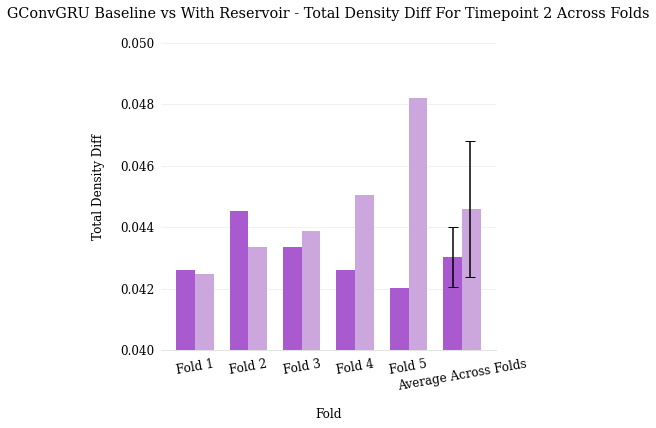

In [56]:
reservoir_density_diff = get_diffs_across_folds(density_diff, predicted_across_all_folds, original_across_all_folds)
baseline_density_diff = get_diffs_across_folds(density_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 0, (0.04,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Total Density Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_density_diff, baseline_density_diff, title, 'Total Density Diff', 1, (0.04,), palette_global)


### Clustering

Mean: 0.010893454807795116
Standard Deviation 0.0010899499193060783
Baseline Mean: 0.010662408749091658
Baseline Standard Deviation 0.0011583515583472727


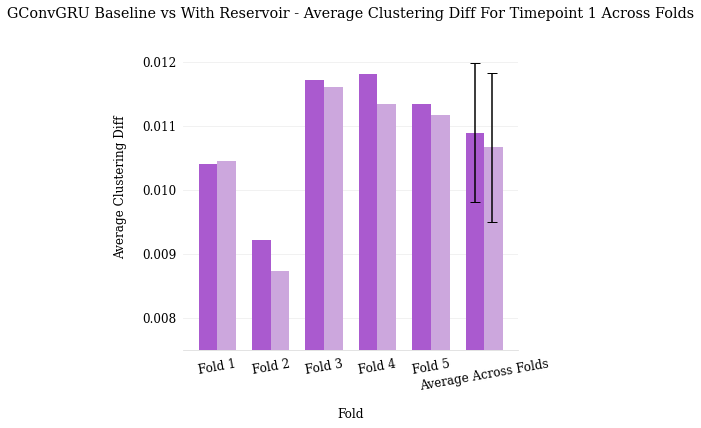

Mean: 0.00965989923743387
Standard Deviation 0.0008227561251901151
Baseline Mean: 0.009350993524745888
Baseline Standard Deviation 0.0006943127767830165


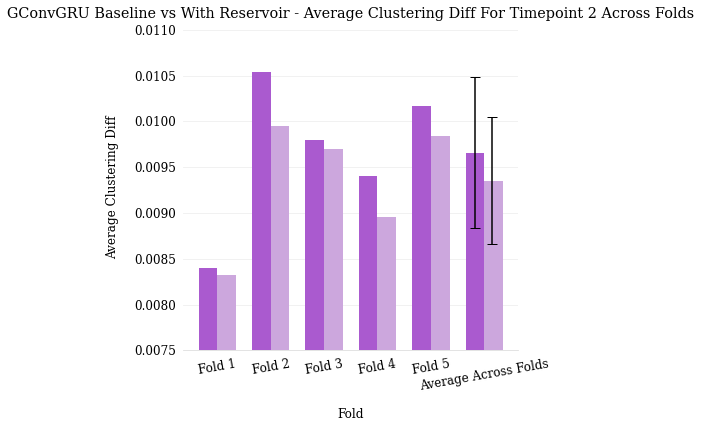

In [64]:
reservoir_clustering_diff = get_diffs_across_folds(clustering_diff, predicted_across_all_folds, original_across_all_folds)
baseline_clustering_diff = get_diffs_across_folds(clustering_diff, baseline_predicted_across_all_folds, baseline_original_across_all_folds)

title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 1 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 0, (0.0075,), palette_global)
title = 'GConvGRU Baseline vs With Reservoir - Average Clustering Diff For Timepoint 2 Across Folds'
plot_comparison(reservoir_clustering_diff, baseline_clustering_diff, title, 'Average Clustering Diff', 1, (0.0075,), palette_global)